In [2]:
###### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, LeaveOneOut, KFold , GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Problem Definition

# 2. Data Collection

# 3. Data preprocessing and Featue Selection

In [4]:
# df = pd.read_csv("credit_risk.csv")
# df.head()

In [5]:
df = pd.read_csv("/content/drive/My Drive/datasets/credit_risk.csv")
df.head()

,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,0.59,Y,3
1,1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,N,2
2,2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,N,3
3,3,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,0.53,N,2
4,4,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,0.55,Y,4


In [6]:
df.shape

(32581, 12)

![image](https://drive.google.com/file/d/12qV-1AFEiQMwem1PO-iOg0keSFja45sK/view?usp=drive_link)

In [388]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       32581 non-null  int64  
 1   Income                    32581 non-null  int64  
 2   Amount                    32581 non-null  int64  
 3   Status                    32581 non-null  int64  
 4   Percent_income            32581 non-null  float64
 5   Default                   32581 non-null  int64  
 6   Cred_length               32581 non-null  int64  
 7   Intent_DEBTCONSOLIDATION  32581 non-null  int64  
 8   Intent_EDUCATION          32581 non-null  int64  
 9   Intent_HOMEIMPROVEMENT    32581 non-null  int64  
 10  Intent_MEDICAL            32581 non-null  int64  
 11  Intent_PERSONAL           32581 non-null  int64  
 12  Intent_VENTURE            32581 non-null  int64  
 13  Home_MORTGAGE             32581 non-null  int64  
 14  Home_O

In [7]:
for column in df:
    print( column,": ", df[column].nunique())

Id :  32581
Age :  58
Income :  4295
Home :  4
Emp_length :  36
Intent :  6
Amount :  753
Rate :  348
Status :  2
Percent_income :  77
Default :  2
Cred_length :  29


## feature selection

In [8]:
df = df.drop("Id", axis = 1)
df.head()

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,0.55,Y,4


## finding and filling missing value

In [9]:
df.isna().sum()

,0
Age,0
Income,0
Home,0
Emp_length,895
Intent,0
Amount,0
Rate,3116
Status,0
Percent_income,0
Default,0


In [10]:
df['Emp_length'].value_counts()

,count
Emp_length,
0.0,4105
2.0,3849
3.0,3456
5.0,2946
1.0,2915
4.0,2874
6.0,2666
7.0,2196
8.0,1687


In [11]:
print(df['Rate'].nunique())
print(df['Rate'].value_counts())

348
Rate
7.51     756
10.99    749
7.49     645
7.88     642
5.42     594
        ... 
21.64      1
20.48      1
17.46      1
21.14      1
20.53      1
Name: count, Length: 348, dtype: int64


In [12]:
tdf = df.dropna(subset=['Rate'])
correlation = [tdf['Rate'].corr(tdf['Percent_income'])]


In [13]:
print(correlation)

[0.12031388883450295]


In [14]:
df['Status'].value_counts()

,count
Status,
0,25473
1,7108


## encoding categorical values

In [15]:
# apply One hot Encoding
encoded_values = pd.get_dummies(df, columns=['Intent','Home'], dtype=int)
encoded_values.head()

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT
0,22,59000,123.0,35000,16.02,1,0.59,Y,3,0,0,0,0,1,0,0,0,0,1
1,21,9600,5.0,1000,11.14,0,0.10,N,2,0,1,0,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,N,3,0,0,0,1,0,0,1,0,0,0
3,23,65500,4.0,35000,15.23,1,0.53,N,2,0,0,0,1,0,0,0,0,0,1
4,24,54400,8.0,35000,14.27,1,0.55,Y,4,0,0,0,1,0,0,0,0,0,1


In [16]:
df = encoded_values
df.head(2)

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT
0,22,59000,123.0,35000,16.02,1,0.59,Y,3,0,0,0,0,1,0,0,0,0,1
1,21,9600,5.0,1000,11.14,0,0.10,N,2,0,1,0,0,0,0,0,0,1,0


In [17]:
df['Default'] = df['Default'].map({'Y':1, 'N':0})
df.head()

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT
0,22,59000,123.0,35000,16.02,1,0.59,1,3,0,0,0,0,1,0,0,0,0,1
1,21,9600,5.0,1000,11.14,0,0.10,0,2,0,1,0,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,0,3,0,0,0,1,0,0,1,0,0,0
3,23,65500,4.0,35000,15.23,1,0.53,0,2,0,0,0,1,0,0,0,0,0,1
4,24,54400,8.0,35000,14.27,1,0.55,1,4,0,0,0,1,0,0,0,0,0,1


In [18]:
df.shape

(32581, 19)

In [19]:
df['Rate'].value_counts()

,count
Rate,
7.51,756
10.99,749
7.49,645
7.88,642
5.42,594
...,...
21.64,1
20.48,1
17.46,1


In [20]:
missing_rate = df[df['Rate'].isna()]
missing_rate

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT
39,23,71500,3.0,30000,NaN,1,0.42,0,4,1,0,0,0,0,0,0,0,0,1
50,24,78000,4.0,30000,NaN,1,0.38,1,4,1,0,0,0,0,0,0,0,0,1
57,23,277000,3.0,35000,NaN,0,0.13,0,4,0,0,0,0,1,0,0,0,1,0
59,24,12000,2.0,1750,NaN,0,0.15,1,3,0,0,0,0,0,1,0,0,1,0
62,26,263000,0.0,10000,NaN,1,0.04,0,4,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32547,53,4888,0.0,1400,NaN,1,0.29,1,28,0,0,0,0,0,1,0,0,1,0
32552,65,45900,2.0,10000,NaN,0,0.22,1,19,0,1,0,0,0,0,0,0,0,1
32553,54,20000,2.0,5000,NaN,0,0.25,0,28,0,0,0,1,0,0,0,0,0,1
32569,51,60000,1.0,7500,NaN,0,0.13,0,23,0,0,0,0,1,0,1,0,0,0


In [21]:
df[df['Emp_length'].isna()]

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT
105,22,12600,NaN,2000,5.42,1,0.16,0,4,0,0,0,0,1,0,1,0,0,0
222,24,185000,NaN,35000,12.42,0,0.19,0,2,0,1,0,0,0,0,1,0,0,0
379,24,16800,NaN,3900,NaN,1,0.23,0,3,1,0,0,0,0,0,1,0,0,0
407,25,52000,NaN,24000,10.74,1,0.46,0,2,0,0,0,0,1,0,0,0,0,1
408,22,17352,NaN,2250,15.27,0,0.13,1,3,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32285,38,12000,NaN,4800,7.29,1,0.40,0,12,0,1,0,0,0,0,0,0,1,0
32328,51,18408,NaN,1000,14.65,1,0.05,1,20,0,0,0,0,1,0,0,0,0,1
32360,70,39996,NaN,3600,15.23,0,0.09,1,19,0,0,0,1,0,0,0,0,0,1
32453,56,32400,NaN,8575,7.51,0,0.26,0,18,0,0,0,1,0,0,0,0,0,1


## use KNN Inputer to fill in the missing Rate values

### for imputing , make sure to impute only the numerical columns with missing values

In [22]:
from sklearn.impute import KNNImputer
import pandas as pd


# Assuming `df` is your DataFrame and 'Rate' is the column with missing values
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors
# features_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)
# df['Rate'] = df['Rate'].fillna(df['Rate'].median())
missing_fields_imputed = pd.DataFrame(imputer.fit_transform(df[['Emp_length','Rate']]), columns=['Emp_length','Rate'])



In [23]:
missing_fields_imputed.head()

,Emp_length,Rate
0,123.0,16.02
1,5.0,11.14
2,1.0,12.87
3,4.0,15.23
4,8.0,14.27


In [24]:
missing_fields_imputed.isna().sum()

,0
Emp_length,0
Rate,0


In [25]:
missing_fields_imputed.shape


(32581, 2)

In [26]:
missing_fields_imputed['Rate'].value_counts()

,count
Rate,
7.51,756
10.99,749
7.49,645
7.88,642
5.42,594
...,...
17.44,1
18.49,1
20.52,1


In [27]:
df.isna().sum()

,0
Age,0
Income,0
Emp_length,895
Amount,0
Rate,3116
Status,0
Percent_income,0
Default,0
Cred_length,0
Intent_DEBTCONSOLIDATION,0


In [28]:
df.head()

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT
0,22,59000,123.0,35000,16.02,1,0.59,1,3,0,0,0,0,1,0,0,0,0,1
1,21,9600,5.0,1000,11.14,0,0.10,0,2,0,1,0,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,0,3,0,0,0,1,0,0,1,0,0,0
3,23,65500,4.0,35000,15.23,1,0.53,0,2,0,0,0,1,0,0,0,0,0,1
4,24,54400,8.0,35000,14.27,1,0.55,1,4,0,0,0,1,0,0,0,0,0,1


In [29]:
df_without_rate_Emp_length = df.drop(["Rate","Emp_length"], axis=1)
df_without_rate_Emp_length.head()

,Age,Income,Amount,Status,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT
0,22,59000,35000,1,0.59,1,3,0,0,0,0,1,0,0,0,0,1
1,21,9600,1000,0,0.10,0,2,0,1,0,0,0,0,0,0,1,0
2,25,9600,5500,1,0.57,0,3,0,0,0,1,0,0,1,0,0,0
3,23,65500,35000,1,0.53,0,2,0,0,0,1,0,0,0,0,0,1
4,24,54400,35000,1,0.55,1,4,0,0,0,1,0,0,0,0,0,1


### combining the df fields with the new ['Rate','Emp_length'] fields with no NA values

In [30]:
missing_fields_imputed.head()

,Emp_length,Rate
0,123.0,16.02
1,5.0,11.14
2,1.0,12.87
3,4.0,15.23
4,8.0,14.27


In [31]:
df_without_rate_Emp_length.shape

(32581, 17)

In [32]:
missing_fields_imputed.shape

(32581, 2)

In [33]:
new_df = pd.concat([df_without_rate_Emp_length, missing_fields_imputed],axis=1)
new_df.head()

,Age,Income,Amount,Status,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Emp_length,Rate
0,22,59000,35000,1,0.59,1,3,0,0,0,0,1,0,0,0,0,1,123.0,16.02
1,21,9600,1000,0,0.10,0,2,0,1,0,0,0,0,0,0,1,0,5.0,11.14
2,25,9600,5500,1,0.57,0,3,0,0,0,1,0,0,1,0,0,0,1.0,12.87
3,23,65500,35000,1,0.53,0,2,0,0,0,1,0,0,0,0,0,1,4.0,15.23
4,24,54400,35000,1,0.55,1,4,0,0,0,1,0,0,0,0,0,1,8.0,14.27


In [34]:
new_df.shape

(32581, 19)

In [35]:
new_df.isna().sum()

,0
Age,0
Income,0
Amount,0
Status,0
Percent_income,0
Default,0
Cred_length,0
Intent_DEBTCONSOLIDATION,0
Intent_EDUCATION,0
Intent_HOMEIMPROVEMENT,0


In [36]:
## updating the original df to contain the new_df withoud missing values
df = new_df

In [37]:
df.shape

(32581, 19)

In [38]:
# splitting the target values from the main dataframe since i don't want it to get scaled so i will just split the data here
target = df['Status']
features = df.drop('Status', axis=1)

In [39]:
# setting the sandom seed to ensure all random operations withing the project use the same seed
np.random.seed(42)

## Data set Spitting

## spliting the data set into feature(x) and target variable(y)

In [40]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(features, target, test_size=0.3)

## balancing the dataset using SMOTE

In [41]:
df['Default'].value_counts()

,count
Default,
0,26836
1,5745


In [42]:
# ! pip install imbalanced-learn

In [43]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
x_resampled, y_resampled = smote.fit_resample(features, target)


In [44]:
features = x_resampled
target = y_resampled
print(features.shape, target.shape)

(50946, 18) (50946,)


In [45]:
# now checking that the dataset is balanced
target.value_counts()

,count
Status,
1,25473
0,25473


# spliting the dataset into training , validation and testing set

### the use part will be used for the training and evaluation of the model while the temp part will be kept aside . part will be used for testing. the reason why am doing this is because the size of the dataset is large and due to this the model takes to long to train since i have limmited computing resource so i have to split the data in two parts so i can train the model faster.

In [46]:
from sklearn.model_selection import train_test_split
# splitting the data into 2 parts use and temp
x_use , x_temp, y_use, y_temp = train_test_split(features, target,test_size=2/4, stratify=target, random_state=42 )



In [47]:
print(" to be used " , x_use.shape, y_use.shape)
print(" to be kept " , x_temp.shape, y_temp.shape)

 to be used  (25473, 18) (25473,)
 to be kept  (25473, 18) (25473,)


In [48]:
# checking to ensure that the part we are going to use contains an even destribution of our target varable
y_use.value_counts()

,count
Status,
1,12737
0,12736


# preparing the Test data

In [49]:
x_temp.shape

(25473, 18)

In [50]:
"""
using StratifiedShuffleSplit fro sklearn to split the data into balanced parts
"""
from sklearn.model_selection import StratifiedShuffleSplit
test_pick = StratifiedShuffleSplit(n_splits=1, test_size=1/3, random_state=42)

In [51]:
x = x_temp
y = y_temp
for train_index, test_index in test_pick.split(x,y):
    x_test = x.iloc[test_index]
    y_test = y.iloc[test_index]


In [52]:
print(f" x_test shape : {x_test.shape} \n y_test shape : {y_test.shape}")

 x_test shape : (8491, 18) 
 y_test shape : (8491,)


In [53]:
y_test.value_counts()

,count
Status,
0,4246
1,4245


## splitting the usable part into training and validation set

In [54]:
x_use.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25473 entries, 41688 to 29774
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       25473 non-null  int64  
 1   Income                    25473 non-null  int64  
 2   Amount                    25473 non-null  int64  
 3   Percent_income            25473 non-null  float64
 4   Default                   25473 non-null  int64  
 5   Cred_length               25473 non-null  int64  
 6   Intent_DEBTCONSOLIDATION  25473 non-null  int64  
 7   Intent_EDUCATION          25473 non-null  int64  
 8   Intent_HOMEIMPROVEMENT    25473 non-null  int64  
 9   Intent_MEDICAL            25473 non-null  int64  
 10  Intent_PERSONAL           25473 non-null  int64  
 11  Intent_VENTURE            25473 non-null  int64  
 12  Home_MORTGAGE             25473 non-null  int64  
 13  Home_OTHER                25473 non-null  int64  
 14  Home_OW

In [55]:
x_use.shape

(25473, 18)

In [56]:
# spliting into training anv validation set using
x_train,x_val,y_train,y_val = train_test_split(x_use, y_use, test_size=0.3)

In [57]:
print(f"x_train{x_train.shape} \n x_val{x_val.shape} \n y_train{y_train.shape} \n y_val{y_val.shape}")

x_train(17831, 18) 
 x_val(7642, 18) 
 y_train(17831,) 
 y_val(7642,)


# 5. Model Selection

# 6. Model training (before Feature Selection)

For traing the models, i am going to follow 5 steps
#### 1. **Train with default parameters:** In this step, the models will be trained with their default parameters
#### 2. **Cross-Validation:** In this step, cross validation will be used to evaluate model's peformance on different subsets of the training data. This helps access the model's generalization ability and identify potential overfitting
#### 3. **Hyperparameter tunning:** In this step, we Tune the model's hyperparameters using technique like **Grid Search**
#### 4. **Retrain with best parameters:** In this step, the model is trained with the best parameters obtained from the previous step
#### 5. **Evaluate on Test set:** In this stage , the model is tested with the test set. This will give the final accessment of the model's peformance

# ◉ KNearestNeighbor model

## &rarr; Training the model with default parameters

In [58]:
from sklearn.neighbors import KNeighborsClassifier
st = time.time()
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)
et = time.time()
print("time taking to train the knn model is : ", et-st)
knn_model

time taking to train the knn model is :  0.013285398483276367


KNeighborsClassifier()

In [59]:
y_pred = knn_model.predict(x_val)

# 7.1 Model evalution for KNearestNeighbor classifier

In [60]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      3837
           1       0.78      0.82      0.80      3805

    accuracy                           0.79      7642
   macro avg       0.79      0.79      0.79      7642
weighted avg       0.79      0.79      0.79      7642



## &rarr; peforming cross-validation

## stratified K-Fold for KNN

In [357]:
st = time.time()
skf = StratifiedKFold(n_splits=5)
knn_model_skf_score = cross_val_score(knn_model, x_use, y_use, cv=skf)
knn_model_skf_avg_score = round(knn_model_skf_score.mean(),3)
print("stratified kfold validation scores are : ", knn_model_skf_score)
print("average score for the stratifiec k fold  : ", knn_model_skf_avg_score )
et = time.time()
print("time taken for stratified kfold cross validation on KNN is: ", et-st)


stratified kfold validation scores are :  [0.8033366  0.80372915 0.79175662 0.79681979 0.79976443]
average score for the stratifiec k fold  :  0.799
time taken for stratified kfold cross validation on KNN is:  4.207082748413086


## Leave One Out for KNN

In [62]:
# loov = LeaveOneOut()
# score = cross_val_score(model, x_use, y_use, cv=loov)
# print(score.mean())
# taking so much time so i left out

## K-Fold cross validation for KNN

In [361]:
st = time.time()
kfold = KFold(n_splits=5)
knn_model_kf_score = cross_val_score(knn_model, x_use, y_use, cv=kfold)
knn_model_kf_avg_score = round(knn_model_kf_score.mean(), 3)
print(knn_model_kf_score)
print("the mean avg score for kfold cross validatin is :", knn_model_kf_avg_score)
et = time.time()
print("time taken for kfold crossvalidaton: ", et-st)


[0.80019627 0.80588813 0.79116781 0.79564193 0.80113859]
the mean avg score for kfold cross validatin is : 0.799
time taken for kfold crossvalidaton:  4.672618389129639


## &rarr; Hyper parameter tunning (KNeighborClassifier)

In [64]:
param_grid={
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_model_grid_search = GridSearchCV(knn_model, param_grid=param_grid, verbose=3, cv=5)
knn_model_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END n_neighbors=3, p=1, weights=uniform;, score=0.795 total time=   2.2s
[CV 2/5] END n_neighbors=3, p=1, weights=uniform;, score=0.808 total time=   1.4s
[CV 3/5] END n_neighbors=3, p=1, weights=uniform;, score=0.797 total time=   1.5s
[CV 4/5] END n_neighbors=3, p=1, weights=uniform;, score=0.789 total time=   1.5s
[CV 5/5] END n_neighbors=3, p=1, weights=uniform;, score=0.805 total time=   1.5s
[CV 1/5] END n_neighbors=3, p=1, weights=distance;, score=0.811 total time=   1.3s
[CV 2/5] END n_neighbors=3, p=1, weights=distance;, score=0.822 total time=   1.3s
[CV 3/5] END n_neighbors=3, p=1, weights=distance;, score=0.815 total time=   1.5s
[CV 4/5] END n_neighbors=3, p=1, weights=distance;, score=0.800 total time=   2.0s
[CV 5/5] END n_neighbors=3, p=1, weights=distance;, score=0.814 total time=   2.0s
[CV 1/5] END n_neighbors=3, p=2, weights=uniform;, score=0.793 total time=   0.6s
[CV 2/5] END n_neighbors=3, p=2

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [65]:
knn_best_parameters = knn_model_grid_search.best_params_
print(f"the best parameters for the knn model are : {knn_best_parameters}")

the best parameters for the knn model are : {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


## &rarr; Retrain with best parameters

In [66]:
final_knn_model = KNeighborsClassifier(n_neighbors=knn_best_parameters['n_neighbors'], p=knn_best_parameters['p'], weights=knn_best_parameters['weights'])
final_knn_model.fit(x_train, y_train)

KNeighborsClassifier(p=1, weights='distance')

In [67]:
y_pred = final_knn_model.predict(x_val)

In [68]:
final_knn_model_report = classification_report(y_val, y_pred)
print(final_knn_model_report)

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      3837
           1       0.80      0.84      0.82      3805

    accuracy                           0.82      7642
   macro avg       0.82      0.82      0.82      7642
weighted avg       0.82      0.82      0.82      7642



## &rarr; evaluate on test set (Testing the model)

In [69]:
knn_test_pred = final_knn_model.predict(x_test)

In [70]:
knn_test_report = classification_report(y_test, knn_test_pred)
accuracy = accuracy_score(y_test, knn_test_pred)
print("accuracy : ", accuracy)
print(knn_test_report)

accuracy :  0.8160405134848663
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      4246
           1       0.80      0.84      0.82      4245

    accuracy                           0.82      8491
   macro avg       0.82      0.82      0.82      8491
weighted avg       0.82      0.82      0.82      8491



In [356]:
knn_test_accuracy = round(accuracy_score(y_test, knn_test_pred),3)
knn_test_recall = round(recall_score(y_test, knn_test_pred),3)
knn_test_precision = round(precision_score(y_test, knn_test_pred),3)
knn_test_f1_score = round(f1_score(y_test, knn_test_pred),3)

print("accuracy : ", knn_test_accuracy)
print("recall : ", knn_test_recall)
print("precision : ", knn_test_precision)
print("f1_score : ", knn_test_f1_score)

accuracy :  0.816
recall :  0.842
precision :  0.8
f1_score :  0.821


# ◉ Decision Tree Algorithm

## &rarr; Training the model with default parameters

In [72]:
from sklearn.tree import DecisionTreeClassifier
st = time.time()
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)
et = time.time()
print("time taken to train the decision tree model: ", et-st)

time taken to train the decision tree model:  0.12151479721069336


In [73]:
y_pred = dt_model.predict(x_val)

# 7.2 Evaluation Report for Decision Tree Classifier

In [74]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      3837
           1       0.88      0.89      0.89      3805

    accuracy                           0.89      7642
   macro avg       0.89      0.89      0.89      7642
weighted avg       0.89      0.89      0.89      7642



## &rarr; peforming cross-validation

## stratified k-Fold for Decision Tree Classifier

In [374]:
# skf stands for Stratified K-Fold
st = time.time()
skf = StratifiedKFold(n_splits=5)
dt_model_skf_score = cross_val_score(dt_model, x_use, y_use, cv=skf)
et = time.time()
dt_model_skf_avg_score = round(dt_model_skf_score.mean(),3)
print("Decision tree skf  average score : ", dt_model_skf_avg_score)
print(dt_model_skf_score)
print("time taken to do k-fold cross validation for decisionTree : ", et-st)

Decision tree skf  average score :  0.894
[0.90225711 0.89028459 0.89656526 0.88947782 0.8932077 ]
time taken to do k-fold cross validation for decisionTree :  0.9690144062042236


## K-Fold cross validation for Desision Tree Classifier

In [375]:
# kf stands for K-Fold
st = time.time()
kf = KFold(n_splits=5)
dt_model_kf_score = cross_val_score(dt_model, x_use, y_use, cv=kf)
et = time.time()
print(dt_model_kf_score)
dt_model_kf_avg_score = round(dt_model_kf_score.mean(),3)
print("Decision tree kf average score : ", dt_model_kf_avg_score)
print("time taken to do  cross validation for decisionTree : ", et-st)

[0.8922473  0.89578018 0.89990186 0.89399293 0.8996859 ]
Decision tree kf average score :  0.896
time taken to do  cross validation for decisionTree :  1.0333712100982666


## &rarr; Hyper parameter tunning

In [77]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

dt_model_grid_search = GridSearchCV(dt_model, param_grid=param_grid, verbose=3, cv=5)
dt_model_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.891 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.887 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.880 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.882 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.876 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.898 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.894 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.884 total time=  

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=3)

In [78]:
dt_model_best_parameters = dt_model_grid_search.best_params_
print(f"the best parameters for the decision tree model are : {dt_model_best_parameters}")

the best parameters for the decision tree model are : {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}


## &rarr; Retrain the model with best parameters

In [79]:
final_dt_model = DecisionTreeClassifier(criterion=dt_model_best_parameters['criterion'], max_depth= dt_model_best_parameters['max_depth'], min_samples_leaf=dt_model_best_parameters['min_samples_leaf'], min_samples_split=dt_model_best_parameters['min_samples_split'])
final_dt_model.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       min_samples_split=10)

In [80]:
y_pred = final_dt_model.predict(x_val)

In [81]:
final_dt_report = classification_report(y_val, y_pred)
print(final_dt_report)

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      3837
           1       0.96      0.85      0.90      3805

    accuracy                           0.91      7642
   macro avg       0.91      0.91      0.91      7642
weighted avg       0.91      0.91      0.91      7642



## &rarr; Evaluate on Test set (Testing the Decision tree model)

In [82]:
dt_test_pred = final_dt_model.predict(x_test)

In [83]:
dt_test_rport = classification_report(y_test, dt_test_pred)
accuracy = accuracy_score(y_test, dt_test_pred)
print("accuracy : ", accuracy)
print(dt_test_rport)

accuracy :  0.9127311270757272
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      4246
           1       0.96      0.86      0.91      4245

    accuracy                           0.91      8491
   macro avg       0.92      0.91      0.91      8491
weighted avg       0.92      0.91      0.91      8491



In [355]:
dt_test_accuracy = round(accuracy_score(y_test, dt_test_pred),3)
dt_test_recall = round(recall_score(y_test, dt_test_pred),3)
dt_test_precision = round(precision_score(y_test, dt_test_pred),3)
dt_test_f1_score = round(f1_score(y_test, dt_test_pred),3)

print("accuracy : ", dt_test_accuracy)
print("recall : ", dt_test_recall)
print("precision : ", dt_test_precision)
print("f1_score : ", dt_test_f1_score)

accuracy :  0.913
recall :  0.859
precision :  0.962
f1_score :  0.908


# ◉ Logistic Regression

## &rarr; Train model with default parameters

In [85]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=6000)
lr_model.fit(x_train, y_train)

LogisticRegression(max_iter=6000)

In [86]:
y_pred = lr_model.predict(x_val)

## 7.3 Evaluation Report for Logistic Regression

In [87]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.76      0.67      0.71      3837
           1       0.70      0.79      0.74      3805

    accuracy                           0.73      7642
   macro avg       0.73      0.73      0.73      7642
weighted avg       0.73      0.73      0.73      7642



## &rarr; peforming cross validation

# Stratified K-Fold for Logistic Regression

In [354]:
skf = StratifiedKFold(n_splits=5)
lr_model_skf_score = cross_val_score(lr_model, x_use, y_use, cv=skf)
lr_model_skf_avg_score = round(lr_model_skf_score.mean(),3)
print(score)
print("the Stratified k-fold sore for logistic regression model is : " , lr_model_skf_score)
print("the Stratified k-fold average sore for logistic regression model is : " , lr_model_skf_avg_score)

[0.73660451 0.72914622 0.7265947  0.73046722 0.73125245]
the Stratified k-fold sore for logistic regression model is :  [0.73660451 0.72914622 0.7265947  0.73046722 0.73125245]
the Stratified k-fold average sore for logistic regression model is :  0.731


## K-Fold cross validation for Logistic Regression

In [353]:
kf = KFold(n_splits=5)
lr_model_kf_score = cross_val_score(lr_model, x_use, y_use, cv=kf)
lr_model_kf_avg_score = round(lr_model_kf_score.mean(),3)
print("the stratified k-fold score for linear regresion model is :", lr_model_kf_score)
print("the stratified k-fold avg score for linear regresion model is :", lr_model_kf_avg_score)

the stratified k-fold score for linear regresion model is : [0.74013739 0.72875368 0.67988224 0.73125245 0.73969376]
the stratified k-fold avg score for linear regresion model is : 0.724


## &rarr; Hyper parameter tunning

In [90]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr_model_grid_search = GridSearchCV(lr_model, param_grid, cv=5, verbose=3, scoring='accuracy')
lr_model_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.743 total time=   0.1s
[CV 2/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.736 total time=   0.1s
[CV 3/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.731 total time=   0.1s
[CV 4/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.718 total time=   0.1s
[CV 5/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.749 total time=   0.1s
[CV 1/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.743 total time=   0.1s
[CV 2/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.739 total time=   0.1s
[CV 3/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.748 total time=   0.1s
[CV 4/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.716 total time=   0.1s
[CV 5/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.752 total time=   0.1s
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.845 total time=   0.1s
[CV 2/5] END C=0

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=6000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy', verbose=3)

In [91]:
lr_model_best_parameters = lr_model_grid_search.best_params_
print(lr_model_best_parameters)

{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


## &rarr; Retrain with best parameters

In [92]:
final_lr_model = LogisticRegression(max_iter=5000)
final_lr_model.fit(x_train, y_train)

LogisticRegression(max_iter=5000)

In [93]:
y_pred = final_lr_model.predict(x_val)

In [94]:
final_lr_model_report = classification_report(y_val, y_pred)
print(final_lr_model_report)

              precision    recall  f1-score   support

           0       0.76      0.67      0.71      3837
           1       0.70      0.79      0.74      3805

    accuracy                           0.73      7642
   macro avg       0.73      0.73      0.73      7642
weighted avg       0.73      0.73      0.73      7642



## &rarr; Evaluate on test set (Testing the model )

In [95]:
lr_test_pred = final_lr_model.predict(x_test)

In [96]:
lr_test_report = classification_report(y_test, lr_test_pred)
print(lr_test_report)

              precision    recall  f1-score   support

           0       0.76      0.67      0.71      4246
           1       0.71      0.79      0.75      4245

    accuracy                           0.73      8491
   macro avg       0.74      0.73      0.73      8491
weighted avg       0.74      0.73      0.73      8491



In [352]:
lr_test_accuracy = round(accuracy_score(y_test, lr_test_pred),3)
lr_test_recall = round(recall_score(y_test, lr_test_pred),3)
lr_test_precision = round(precision_score(y_test, lr_test_pred),3)
lr_test_f1_score = round(f1_score(y_test, lr_test_pred),3)

print("accuracy : ", lr_test_accuracy)
print("recall : ", lr_test_recall)
print("precision : ", lr_test_precision)
print("f1_score : ", lr_test_f1_score)

accuracy :  0.732
recall :  0.793
precision :  0.707
f1_score :  0.748


# ◉ Naive Bayes Algorithm

## &rarr; Training the model with default parameter

In [98]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)

GaussianNB()

In [99]:
y_pred = nb_model.predict(x_val)

# 7.4 Model evaluation for GaussianNB

In [100]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.76      0.49      0.59      3837
           1       0.62      0.84      0.71      3805

    accuracy                           0.66      7642
   macro avg       0.69      0.66      0.65      7642
weighted avg       0.69      0.66      0.65      7642



## &rarr; Peforming cross validation

## stratified K-Fold for GaussianNB

In [351]:
skf = StratifiedKFold(n_splits=5)
nb_model_skf_score = cross_val_score(nb_model, x_use, y_use, cv=skf)
print(nb_model_skf_score)
nb_model_skf_avg_score = round(nb_model_skf_score.mean(),3)
print("GaussianNB stratified k-fold score : ", nb_model_skf_avg_score)

[0.67831207 0.68302257 0.66614328 0.67923047 0.66450726]
GaussianNB stratified k-fold score :  0.674


## K-Fold for GaussianNB

In [363]:
kf = KFold(n_splits=5)
nb_model_kf_score = cross_val_score(nb_model, x_use, y_use, cv=kf)
print(nb_model_kf_score)
nb_model_kf_avg_score = round(nb_model_kf_score.mean(),3)

print("the mean avg score for GausianNB kfold cross validatin is :", nb_model_kf_avg_score)

[0.67556428 0.6861629  0.65809617 0.68099725 0.67314488]
the mean avg score for GausianNB kfold cross validatin is : 0.675


## &rarr; Hyper Parameter tunning

In [103]:
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

nb_model_grid_search = GridSearchCV(nb_model, param_grid=param_grid, verbose=3, cv=5)
nb_model_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...............var_smoothing=1e-09;, score=0.673 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-09;, score=0.680 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-09;, score=0.679 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-09;, score=0.669 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-09;, score=0.678 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-08;, score=0.639 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-08;, score=0.630 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-08;, score=0.647 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-08;, score=0.622 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-08;, score=0.636 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-07;, score=0.609 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-07;,

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]},
             verbose=3)

In [104]:
nb_model_best_parameters = nb_model_grid_search.best_params_
print(nb_model_best_parameters)

{'var_smoothing': 1e-09}


## &rarr; Retrain the model with best parameters

In [105]:
final_nb_model = GaussianNB(var_smoothing=nb_model_best_parameters['var_smoothing'])
final_nb_model.fit(x_train, y_train)

GaussianNB()

In [106]:
y_pred = final_nb_model.predict(x_val)

In [107]:
final_nb_model_report = classification_report(y_val,y_pred)
print(final_nb_model_report)

              precision    recall  f1-score   support

           0       0.76      0.49      0.59      3837
           1       0.62      0.84      0.71      3805

    accuracy                           0.66      7642
   macro avg       0.69      0.66      0.65      7642
weighted avg       0.69      0.66      0.65      7642



## &rarr; Evaluate GaussianNB model on the test set

In [108]:
nb_test_pred = final_nb_model.predict(x_test)

In [109]:
nb_test_report = classification_report(y_test, nb_test_pred)
print(nb_test_report)

              precision    recall  f1-score   support

           0       0.77      0.51      0.62      4246
           1       0.64      0.85      0.73      4245

    accuracy                           0.68      8491
   macro avg       0.71      0.68      0.67      8491
weighted avg       0.71      0.68      0.67      8491



In [350]:
nb_test_accuracy = round(accuracy_score(y_test, nb_test_pred),3)
nb_test_recall = round(recall_score(y_test, nb_test_pred),3)
nb_test_precision = round(precision_score(y_test, nb_test_pred),3)
nb_test_f1_score = round(f1_score(y_test, nb_test_pred),3)

print("accuracy : ", nb_test_accuracy)
print("recall : ", nb_test_recall)
print("precision : ", nb_test_precision)
print("f1_score : ", nb_test_f1_score)

accuracy :  0.682
recall :  0.849
precision :  0.636
f1_score :  0.728


# ◉ Support Vector Classifier

## &rarr; Train with default parameters

In [111]:
from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(x_train, y_train)

SVC()

In [112]:
y_pred = svc_model.predict(x_val)

## 7.5 Model evaluation for Support Vector Classifier

In [113]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.67      0.78      0.72      3837
           1       0.74      0.62      0.67      3805

    accuracy                           0.70      7642
   macro avg       0.71      0.70      0.70      7642
weighted avg       0.71      0.70      0.70      7642



## &rarr; Peforming cross-validation

## stratified K-fold for SVC

In [349]:
st = time.time()
skf = StratifiedKFold(n_splits=5)
svc_model_skf_score = cross_val_score(svc_model, x_use, y_use, cv=skf)
svc_model_skf_avg_score = round(svc_model_skf_score.mean(),3)
et = time.time()
print("time taken for stratified kfold cross validation on SVC is: ", et-st)
print(svc_model_skf_score)
print("the mean avg score for SVC kfold cross validatin is :", svc_model_skf_avg_score)


time taken for stratified kfold cross validation on SVC is:  135.45186138153076
[0.7077527  0.69676153 0.69774289 0.70612485 0.70573223]
the mean avg score for SVC kfold cross validatin is : 0.703


## K-Fold cross vallidation for SVC

In [365]:
st = time.time()
kf = KFold(n_splits=5)
svc_model_kf_score = cross_val_score(svc_model, x_use, y_use, cv=kf)
svc_model_kf_avg_score = round(svc_model_kf_score.mean(),3)
print(svc_model_kf_score)
print("the mean avg score for SVC kfold cross validatin is :", svc_model_kf_avg_score)
et = time.time()
print("time taken for kfold crossvalidaton: ", et-st)

[0.70853778 0.69617272 0.70049068 0.70416176 0.704947  ]
the mean avg score for SVC kfold cross validatin is : 0.703
time taken for kfold crossvalidaton:  140.8264365196228
[0.73660451 0.72914622 0.7265947  0.73046722 0.73125245]


## &rarr; Hyper parameter tunning

In [116]:
# commented it out because is taking too long to execute
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['linear', 'rbf'],
#     'gamma': [0.001, 0.01, 0.1, 1, 10],
#     'degree': [3, 4, 5]  # Only relevant for 'poly' kernel
# }

# svc_model_grid_search = GridSearchCV(svc_model, param_grid=param_grid, verbose=3, cv=5)
# svc_model_grid_search.fit(x_train, y_train)

In [117]:
# svc_model_best_parameters = svc_model_grid_search.best_params_
# print(svc_model_best_parameters)

## &rarr; Retrain SVC with best parameter

In [118]:
# final_svc_model = SVC(C=svc_model_best_parameters['C'], degree=svc_model_best_parameters['degree'], gamma=svc_model_best_parameters['gamma'], kernel=svc_model_best_parameters['kernel'])
# final_svc_model.fit(x_train, y_train)

In [119]:
final_svc_model = SVC()
final_svc_model.fit(x_train, y_train)

SVC()

In [120]:
y_pred = final_svc_model.predict(x_val)

In [121]:
final_svc_model_report = classification_report(y_val, y_pred)
print(final_svc_model_report)

              precision    recall  f1-score   support

           0       0.67      0.78      0.72      3837
           1       0.74      0.62      0.67      3805

    accuracy                           0.70      7642
   macro avg       0.71      0.70      0.70      7642
weighted avg       0.71      0.70      0.70      7642



## &rarr; Evalate on test set (Testing the SVC model)

In [122]:
svc_test_pred = final_svc_model.predict(x_test)

In [123]:
svc_test_report = classification_report(y_test, svc_test_pred)
print(svc_test_report)

              precision    recall  f1-score   support

           0       0.67      0.77      0.72      4246
           1       0.73      0.62      0.67      4245

    accuracy                           0.69      8491
   macro avg       0.70      0.69      0.69      8491
weighted avg       0.70      0.69      0.69      8491



In [347]:
svc_test_accracy = round(accuracy_score(y_test, svc_test_pred),3)
svc_test_recall = round(recall_score(y_test, svc_test_pred),3)
svc_test_precision = round(precision_score(y_test, svc_test_pred),3)
svc_test_f1_score = round(f1_score(y_test, svc_test_pred),3)

print("accuracy : ", svc_test_accracy)
print("recall : ", svc_test_recall)
print("precision : ", svc_test_precision)
print("f1_score : ", svc_test_f1_score)

accuracy :  0.694
recall :  0.621
precision :  0.727
f1_score :  0.67


# Ensemble models

# ◉ Random Forest Classifier

## &rarr; Train With Default parameters

In [125]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)

RandomForestClassifier()

In [126]:
y_pred = rf_model.predict(x_val)

# **7.6 Model Evaluation for Random Forest Classifier**

In [127]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      3837
           1       0.96      0.90      0.93      3805

    accuracy                           0.93      7642
   macro avg       0.93      0.93      0.93      7642
weighted avg       0.93      0.93      0.93      7642



## &rarr; Peforming cross- validation

## Stratified K-Fold for Random Forest Classifier

In [345]:
st = time.time()
skf = StratifiedKFold(n_splits=5)
rf_model_skf_score = cross_val_score(rf_model, x_use, y_use, cv=skf)
rf_model_skf_avg_score = round(rf_model_skf_score.mean(),3)
et = time.time()
print("time taken for stratified kfold cross validation on Random Forest is: ", et-st)
print(rf_model_skf_score)
print("the mean avg score for Random Forest Classifier kfold cross validatin is :", rf_model_skf_avg_score)
print(score)

time taken for stratified kfold cross validation on Random Forest is:  17.109543323516846
[0.93621197 0.93680079 0.93797841 0.92972124 0.93835885]
the mean avg score for Random Forest Classifier kfold cross validatin is : 0.936
[0.73660451 0.72914622 0.7265947  0.73046722 0.73125245]


## K-Fold cross validation for Random Forest Classifier

In [346]:
st = time.time()
kf = KFold(n_splits=5)
rf_model_kf_score = cross_val_score(rf_model, x_use, y_use, cv=kf)
rf_model_kf_avg_score = round(rf_model_kf_score.mean(),3)
et = time.time()
print("time taken for kfold cross validation on Random Forest is: ", et-st)
print(rf_model_kf_score)
print("the mean avg score for Random Forest Classifier kfold cross validatin is :", rf_model_kf_avg_score)


time taken for kfold cross validation on Random Forest is:  17.424594402313232
[0.93876349 0.93778214 0.94190383 0.93070279 0.93816254]
the mean avg score for Random Forest Classifier kfold cross validatin is : 0.937


## &rarr; Hyper parameter tunning

In [130]:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2'],

# }

# rf_model_grid_search = GridSearchCV(rf_model, param_grid=param_grid, cv=5)
# rf_model_grid_search.fit(x_train, y_train)

In [131]:
# rf_model_best_parameters = rf_model_grid_search.best_params_
# print(rf_model_best_parameters)

In [132]:
# since fine tunning the random forest model takes a long time aroung 40minutes i decided to just save the best parameters to use when needed to avoid running the tunning again
rf_model_best_parameters = {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
print(rf_model_best_parameters)

{'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


## &rarr; Retrain the RandomForest model with best parameters

In [133]:
final_rf_model = RandomForestClassifier(n_estimators=rf_model_best_parameters['n_estimators'], max_depth=rf_model_best_parameters['max_depth'], min_samples_leaf=rf_model_best_parameters['min_samples_leaf'], min_samples_split=rf_model_best_parameters['min_samples_split'], max_features=rf_model_best_parameters['max_features'])
final_rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=30, max_features='log2', n_estimators=200)

In [134]:
y_pred = final_rf_model.predict(x_val)

In [135]:
final_rf_model_report = classification_report(y_val, y_pred)
print(final_rf_model_report)

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      3837
           1       0.96      0.90      0.93      3805

    accuracy                           0.93      7642
   macro avg       0.93      0.93      0.93      7642
weighted avg       0.93      0.93      0.93      7642



## &rarr; Evaluate on test set (Testing the model )

In [136]:
rf_test_pred = final_rf_model.predict(x_test)

In [137]:
rf_test_report = classification_report(y_test, rf_test_pred)
print(rf_test_report)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4246
           1       0.97      0.90      0.93      4245

    accuracy                           0.93      8491
   macro avg       0.94      0.93      0.93      8491
weighted avg       0.94      0.93      0.93      8491



In [344]:
rf_test_accuracy = round(accuracy_score(y_test, rf_test_pred),3)
rf_test_recall = round(recall_score(y_test, rf_test_pred),3)
rf_test_precision = round(precision_score(y_test, rf_test_pred),3)
rf_test_f1_score = round(f1_score(y_test, rf_test_pred),3)

print("accuracy : ", rf_test_accuracy)
print("recall : ", rf_test_recall)
print("precision : ", rf_test_precision)
print("f1_score : ", rf_test_f1_score)

accuracy :  0.935
recall :  0.9
precision :  0.967
f1_score :  0.932


# ◉ Bagging Classifier

## &rarr; Training the model with default parameters

In [139]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier()
bagging.fit(x_train, y_train)

BaggingClassifier()

In [140]:
y_pred = bagging.predict(x_val)

## 7.6 Model Evaluation for BaggingClassifier

In [141]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      3837
           1       0.96      0.87      0.91      3805

    accuracy                           0.92      7642
   macro avg       0.92      0.92      0.92      7642
weighted avg       0.92      0.92      0.92      7642



## &rarr; Peforming Cross-Validation

## KFold cross validation for BaggingClassifier

In [342]:
st = time.time()
kf = KFold(n_splits=5)
bagging_kf_score = cross_val_score(bagging, x_use, y_use, cv=kf)
bagging_kf_avg_score = round(bagging_kf_score.mean(),3)
et = time.time()
print("time taken for kfold cross validation on Bagging Classifier is: ", et-st)
print(bagging_kf_score)
print("the mean avg score for Bagging Classifier kfold cross validatin is :", bagging_kf_avg_score)

time taken for kfold cross validation on Bagging Classifier is:  5.676311254501343
[0.9279686  0.9252208  0.92580962 0.91303494 0.92186887]
the mean avg score for Bagging Classifier kfold cross validatin is : 0.923


## Stratified K-Fold for BaggingClassifier

In [343]:
st = time.time()
skf = StratifiedKFold(n_splits=5)
bagging_skf_score = cross_val_score(bagging, x_use, y_use, cv=skf)
bagging_skf_avg_score = round(bagging_skf_score.mean(),3)
et = time.time()
print("time taken for stratified kfold cross validation on Bagging Classifier is: ", et-st)
print(bagging_skf_score)
print("the mean avg score for Bagging Classifier kfold cross validatin is :", bagging_skf_avg_score)

time taken for stratified kfold cross validation on Bagging Classifier is:  4.630208969116211
[0.92757605 0.92757605 0.92836114 0.91323125 0.92520612]
the mean avg score for Bagging Classifier kfold cross validatin is : 0.924


## &rarr; Hyper Parameter tunning for BaggingClassifier

[view the bagging parameter tunning here](https://drive.google.com/file/d/12qV-1AFEiQMwem1PO-iOg0keSFja45sK/view?usp=drive_link)

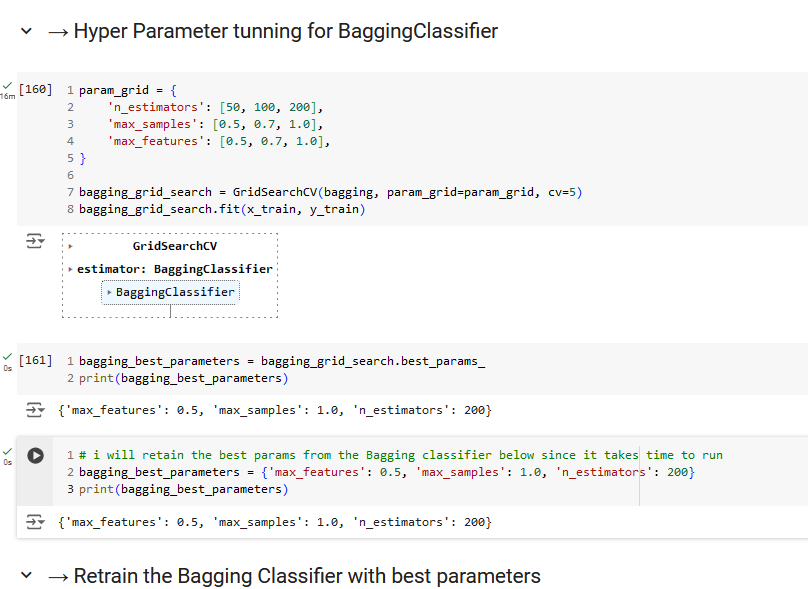

In [386]:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_samples': [0.5, 0.7, 1.0],
#     'max_features': [0.5, 0.7, 1.0],
# }

# bagging_grid_search = GridSearchCV(bagging, param_grid=param_grid, cv=5)
# bagging_grid_search.fit(x_train, y_train)

In [387]:
# bagging_best_parameters = bagging_grid_search.best_params_
# print(bagging_best_parameters)

In [146]:
# i will retain the best params from the Bagging classifier below since it takes time to run
bagging_best_parameters = {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 200}
print(bagging_best_parameters)

{'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 200}


## &rarr; Retrain the Bagging Classifier with best parameters

In [147]:
final_bagging_model = BaggingClassifier(n_estimators=bagging_best_parameters['n_estimators'], max_samples=bagging_best_parameters['max_samples'], max_features=bagging_best_parameters['max_features'])
final_bagging_model.fit(x_train, y_train)

BaggingClassifier(max_features=0.5, n_estimators=200)

In [148]:
y_pred = final_bagging_model.predict(x_val)

In [149]:
final_bagging_model_report = classification_report(y_val, y_pred)
print(final_bagging_model_report)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      3837
           1       0.98      0.90      0.94      3805

    accuracy                           0.94      7642
   macro avg       0.94      0.94      0.94      7642
weighted avg       0.94      0.94      0.94      7642



## &rarr; Evaluate on test set (Testing the model )

In [150]:
bagging_test_pred = final_bagging_model.predict(x_test)

In [151]:
bagging_test_report = classification_report(y_test, bagging_test_pred)
print(bagging_test_report)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      4246
           1       0.98      0.90      0.94      4245

    accuracy                           0.94      8491
   macro avg       0.94      0.94      0.94      8491
weighted avg       0.94      0.94      0.94      8491



In [341]:
bagging_test_accuracy = round(accuracy_score(y_test, bagging_test_pred),3)
bagging_test_recall = round(recall_score(y_test, bagging_test_pred),3)
bagging_test_precision = round(precision_score(y_test, bagging_test_pred),3)
bagging_test_f1_score = round(f1_score(y_test, bagging_test_pred),3)

print("accuracy : ", bagging_test_accuracy)
print("recall : ", bagging_test_recall)
print("precision : ", bagging_test_precision)
print("f1_score : ", bagging_test_f1_score)

accuracy :  0.941
recall :  0.9
precision :  0.98
f1_score :  0.938


# ◉ Xgboost Classifier

In [153]:
! pip install --user xgboost

## &rarr; Traing with default parameters

In [154]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## 7.7 Model evaluation for xgb classifier

In [155]:
y_pred = xgb.predict(x_val)

In [156]:
clr = classification_report(y_val,y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3837
           1       0.97      0.91      0.94      3805

    accuracy                           0.94      7642
   macro avg       0.94      0.94      0.94      7642
weighted avg       0.94      0.94      0.94      7642



## &rarr; Peforming cross-validation

## Stratified k-Fold for XGBClassifier

In [376]:
st = time.time()
skf = StratifiedKFold(n_splits=5)
xgb_skf_score = cross_val_score(xgb, x_use, y_use, cv=skf)
xgb_skf_avg_score = round(xgb_skf_score.mean(),3)
et = time.time()
print("time taken for stratified kfold cross validation on XGBClassifier is: ", et-st)
print(xgb_skf_score)
print("the mean avg score for XGBClassifier kfold cross validatin is :", xgb_skf_avg_score)

time taken for stratified kfold cross validation on XGBClassifier is:  1.9567618370056152
[0.94661433 0.94308145 0.94759568 0.94071457 0.94660385]
the mean avg score for XGBClassifier kfold cross validatin is : 0.945


## K-Fold Cross validation for XGBClassifier

In [377]:
st = time.time()
kf = KFold(n_splits=5)
xgb_kf_score = cross_val_score(xgb, x_use, y_use, cv=kf)
xgb_kf_avg_score = round(xgb_kf_score.mean(),3)
et = time.time()
print("time taken for kfold cross validation on XGBClassifier is: ", et-st)
print(xgb_kf_score)
print("the mean avg score for XGBClassifier kfold cross validatin is :", xgb_kf_avg_score)

time taken for kfold cross validation on XGBClassifier is:  2.3665802478790283
[0.94465162 0.94504416 0.94641806 0.94110718 0.94365921]
the mean avg score for XGBClassifier kfold cross validatin is : 0.944


## &rarr; Hyper parameter Tunning

In [159]:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'min_child_weight': [1, 5, 10],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
# }

# xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# xgb_grid_search.fit(x_train, y_train)

In [160]:
# xgb_best_parameters = xgb_grid_search.best_params_
# print(xgb_best_parameters)

In [161]:
xgb_best_parameters = {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
print(xgb_best_parameters)

{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


## &rarr; Retrain with best parameter

In [162]:
final_xgb_model = XGBClassifier(n_estimators=xgb_best_parameters['n_estimators'], learning_rate=xgb_best_parameters['learning_rate'], max_depth=xgb_best_parameters['max_depth'], min_child_weight=xgb_best_parameters['min_child_weight'], subsample=xgb_best_parameters['subsample'], colsample_bytree=xgb_best_parameters['colsample_bytree'])
final_xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [163]:
y_pred = final_xgb_model.predict(x_val)

In [164]:
final_xgb_model_report = classification_report(y_val, y_pred)
print(final_xgb_model_report)

              precision    recall  f1-score   support

           0       0.92      0.98      0.94      3837
           1       0.97      0.91      0.94      3805

    accuracy                           0.94      7642
   macro avg       0.94      0.94      0.94      7642
weighted avg       0.94      0.94      0.94      7642



## &rarr; Evaluate on Test set (Testing)

In [165]:
xgb_test_pred = final_xgb_model.predict(x_test)

In [166]:
xgb_test_report = classification_report(y_test, xgb_test_pred)
print(xgb_test_report)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4246
           1       0.97      0.91      0.94      4245

    accuracy                           0.94      8491
   macro avg       0.95      0.94      0.94      8491
weighted avg       0.95      0.94      0.94      8491



In [340]:
xgb_test_accuracy = round(accuracy_score(y_test, xgb_test_pred),3)
xgb_test_recall = round(recall_score(y_test, xgb_test_pred),3)
xgb_test_precision = round(precision_score(y_test, xgb_test_pred),3)
xgb_test_f1_score = round(f1_score(y_test, xgb_test_pred),3)

print("accuracy : ", xgb_test_accuracy)
print("recall : ", xgb_test_recall)
print("precision : ", xgb_test_precision)
print("f1_score : ", xgb_test_f1_score)

accuracy :  0.943
recall :  0.91
precision :  0.975
f1_score :  0.941


# ◉ Stacking Classifier

## &rarr; Traing with default parameters

In [168]:
from sklearn.ensemble import StackingClassifier
st = time.time()
level0 = list()
level0.append(('lr', final_lr_model ))
level0.append(('knn', final_knn_model ))
level0.append(('Dtree', final_dt_model ))
level0.append(('svm', final_svc_model ))
level0.append(('rf', final_rf_model ))
level0.append(('bagging', final_bagging_model ))


level1 = XGBClassifier()

stacking_model = StackingClassifier(estimators=level0, final_estimator=level1)
stacking_model.fit(x_train, y_train)

et = time.time()
print("time taken for stacking classifier is : ", et-st)
stacking_model

time taken for stacking classifier is :  185.91637086868286


StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=5000)),
                               ('knn',
                                KNeighborsClassifier(p=1, weights='distance')),
                               ('Dtree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=10,
                                                       min_samples_leaf=2,
                                                       min_samples_split=10)),
                               ('svm', SVC()),
                               ('rf',
                                RandomForestClassifier(max_depth=30,
                                                       max_features='log2',
                                                       n_estimators=200)),
                               ('bagging',
                                BaggingClass...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...))

In [169]:
y_pred = stacking_model.predict(x_val)

In [170]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3837
           1       0.96      0.92      0.94      3805

    accuracy                           0.94      7642
   macro avg       0.94      0.94      0.94      7642
weighted avg       0.94      0.94      0.94      7642



## &rarr; Peforming Cross Validation

## KFold Cross Validation  for Stacking model

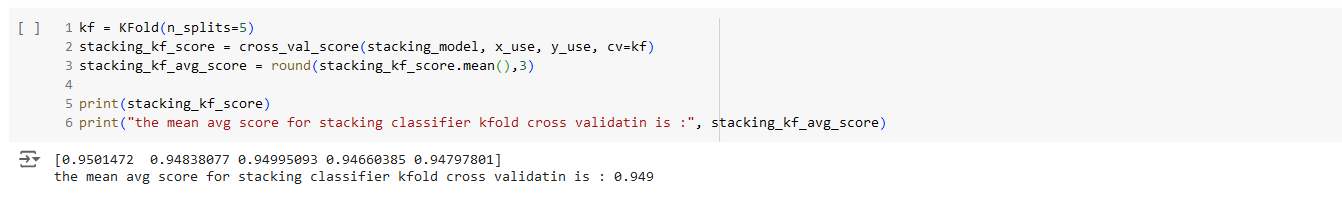

In [379]:
# kf = KFold(n_splits=5)
# stacking_kf_score = cross_val_score(stacking_model, x_use, y_use, cv=kf)
# stacking_kf_avg_score = round(stacking_kf_score.mean(),3)

# print(stacking_kf_score)
# print("the mean avg score for stacking classifier kfold cross validatin is :", stacking_kf_avg_score)

[0.9501472  0.94838077 0.94995093 0.94660385 0.94797801]
the mean avg score for stacking classifier kfold cross validatin is : 0.949


In [383]:
stacking_kf_score = [0.9501472 , 0.94838077, 0.94995093, 0.94660385, 0.94797801]
stacking_kf_avg_score = 0.949

## Stratified KFold Cross validation

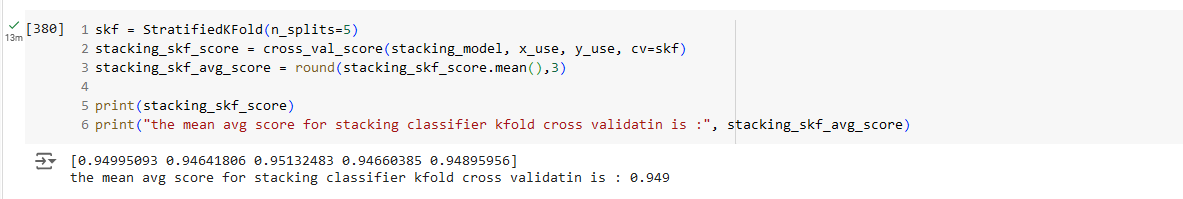

In [380]:
# skf = StratifiedKFold(n_splits=5)
# stacking_skf_score = cross_val_score(stacking_model, x_use, y_use, cv=skf)
# stacking_skf_avg_score = round(stacking_skf_score.mean(),3)

# print(stacking_skf_score)
# print("the mean avg score for stacking classifier kfold cross validatin is :", stacking_skf_avg_score)

[0.94995093 0.94641806 0.95132483 0.94660385 0.94895956]
the mean avg score for stacking classifier kfold cross validatin is : 0.949


In [384]:
stacking_skf_score = [0.94995093, 0.94641806, 0.95132483 ,0.94660385, 0.94895956]
stacking_skf_avg_score = 0.949

## &rarr; Hyper parameter Tunning

#### for Stacking i used the already hypertuned models above so there is no need tunning the models again

## &rarr; Retrain with best parameter

In [171]:
# In this case the originally trained stacking model above will be used as the final stacking model
final_stacking_model = stacking_model

## &rarr; Evaluate on Test set (Testing)

In [172]:
stacking_test_pred = final_stacking_model.predict(x_test)

In [173]:
stacking_test_report = classification_report(y_test, stacking_test_pred)
print(stacking_test_report)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      4246
           1       0.96      0.92      0.94      4245

    accuracy                           0.94      8491
   macro avg       0.94      0.94      0.94      8491
weighted avg       0.94      0.94      0.94      8491



In [339]:
stacking_test_accuracy = round(accuracy_score(y_test, stacking_test_pred),3)
stacking_test_recall = round(recall_score(y_test, stacking_test_pred),3)
stacking_test_precision = round(precision_score(y_test, stacking_test_pred),3)
stacking_test_f1_score = round(f1_score(y_test,stacking_test_pred),3)

print("accuracy : ", stacking_test_accuracy)
print("recall : ", stacking_test_recall)
print("precision : ", stacking_test_precision)
print("f1_score : ", stacking_test_f1_score)

accuracy :  0.943
recall :  0.919
precision :  0.965
f1_score :  0.941


In [385]:
import plotly.graph_objects as go
model_names = ['KNN', 'DTC', 'Logistic R', 'Naive B', 'SVC', 'Random F', 'Bagging', 'XGB', 'Stacking']
precision_values = [knn_test_precision, dt_test_precision, lr_test_precision, nb_test_precision, svc_test_precision,rf_test_precision, bagging_test_precision , xgb_test_precision, stacking_test_precision]
recall_values = [knn_test_recall, dt_test_recall, lr_test_recall, nb_test_recall, svc_test_recall, rf_test_recall, bagging_test_recall, xgb_test_recall, stacking_test_recall]
f1_score_values = [knn_test_f1_score, dt_test_f1_score, lr_test_f1_score, nb_test_f1_score, svc_test_f1_score, rf_test_f1_score, bagging_test_f1_score, xgb_test_f1_score, stacking_test_f1_score]
kf_cv_avg_score = [knn_model_kf_avg_score, dt_model_kf_avg_score, lr_model_kf_avg_score, nb_model_kf_avg_score, svc_model_kf_avg_score, rf_model_kf_avg_score, bagging_kf_avg_score, xgb_kf_avg_score, stacking_kf_avg_score ]
skf_cv_avg_score = [knn_model_skf_avg_score, dt_model_skf_avg_score, lr_model_kf_avg_score, nb_model_skf_avg_score, svc_model_skf_avg_score, rf_model_skf_avg_score, bagging_skf_avg_score, xgb_skf_avg_score, stacking_skf_avg_score ]

max_precision_value = max(precision_values)
max_recall_value = max(recall_values)
max_f1_score_value = max(f1_score_values)
max_kf_avg_score = max(kf_cv_avg_score)
max_skf_avg_score = max(skf_cv_avg_score)
# Create table
fig = go.Figure(data=[go.Table(
    header=dict(values=["Model", "precision", "recall", "f1-score", "k-Fold_CV", "SK-Fold_CV"]),
    cells=dict(
        values=[
          model_names,
          precision_values,
          recall_values,
          f1_score_values,
          kf_cv_avg_score,
          skf_cv_avg_score

        ],
        fill=dict(
             color=[
                 ['#FFF'] * len(model_names),
                 ['#90EE90' if precision == max_precision_value else '#FFF' for precision in precision_values],
                 ['#90EE90' if recall == max_recall_value else '#FFF' for recall in recall_values],
                 ['#90EE90' if f1_score == max_f1_score_value else '#FFF' for f1_score in f1_score_values],
                 ['#90EE90' if kf_avg_score == max_kf_avg_score else '#FFF' for kf_avg_score in kf_cv_avg_score],
                 ['#90EE90' if skf_avg_score == max_skf_avg_score else '#FFF' for skf_avg_score in skf_cv_avg_score]


              ],
        ),
        align="center",

    )

)])

fig.show()


# 8. Feature Selection

In [176]:

categorical_variables = ['Default', 'Intent_DEBTCONSOLIDATION', 'Intent_EDUCATION', 'Intent_HOMEIMPROVEMENT', 'Intent_MEDICAL', 'Intent_PERSONAL', 'Intent_VENTURE', 'Home_MORTGAGE', 'Home_OTHER', 'Home_OWN', 'Home_RENT']


In [177]:
features.head()

,Age,Income,Amount,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Emp_length,Rate
0,22,59000,35000,0.59,1,3,0,0,0,0,1,0,0,0,0,1,123.0,16.02
1,21,9600,1000,0.10,0,2,0,1,0,0,0,0,0,0,1,0,5.0,11.14
2,25,9600,5500,0.57,0,3,0,0,0,1,0,0,1,0,0,0,1.0,12.87
3,23,65500,35000,0.53,0,2,0,0,0,1,0,0,0,0,0,1,4.0,15.23
4,24,54400,35000,0.55,1,4,0,0,0,1,0,0,0,0,0,1,8.0,14.27


In [178]:
categorical_df = x_use[categorical_variables]
categorical_df.head()

,Default,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT
41688,0,0,0,0,0,0,0,1,0,0,0
2871,0,0,1,0,0,0,0,0,0,0,1
28801,1,0,1,0,0,0,0,0,0,0,1
28247,0,0,0,0,0,0,1,0,0,0,1
25166,0,0,0,0,0,0,1,0,0,0,1


# 8.1 Filter method

## chi square test

In [179]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Assuming `categorical_df` and `target` are already defined
x = categorical_df
y = y_use

print(x.shape, y.shape)

# Define and apply the MinMaxScaler to ensure non-negative values
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

# Perform the chi-squared test
chi2_values, p_values = chi2(x_scaled, y)

# Create a DataFrame to view the results
chi2_df = pd.DataFrame({
    'Feature': x.columns,
    'Chi2 Value': chi2_values,
    'p-value': p_values
}).sort_values(by='Chi2 Value', ascending=False)

print("Chi-Squared Test Results:")
print(chi2_df)



(25473, 11) (25473,)
Chi-Squared Test Results:
                     Feature   Chi2 Value        p-value
7              Home_MORTGAGE  2251.965701   0.000000e+00
6             Intent_VENTURE  1125.638144  8.843790e-247
2           Intent_EDUCATION  1041.709117  1.543086e-228
9                   Home_OWN   836.870151  5.200551e-184
5            Intent_PERSONAL   723.535055  2.280190e-159
10                 Home_RENT   367.660889   6.046380e-82
3     Intent_HOMEIMPROVEMENT   207.924148   3.897340e-47
4             Intent_MEDICAL   202.781681   5.162109e-46
1   Intent_DEBTCONSOLIDATION   133.045430   8.836636e-31
0                    Default    20.029173   7.626968e-06
8                 Home_OTHER     3.630729   5.672197e-02


In [180]:
selected_names = []
fields = chi2_df[chi2_df['p-value'] <= 0]
fields
for x in fields['Feature']:
    selected_names.append(x)

print(selected_names)


['Home_MORTGAGE']


In [181]:
categorical_variables
non_categorical_columns = [col for col in features.columns if col not in categorical_variables]
non_categorical_columns


['Age',
 'Income',
 'Amount',
 'Percent_income',
 'Cred_length',
 'Emp_length',
 'Rate']

In [182]:
non_categorical_columns.extend(selected_names)
df[non_categorical_columns]

,Age,Income,Amount,Percent_income,Cred_length,Emp_length,Rate,Home_MORTGAGE
0,22,59000,35000,0.59,3,123.0,16.02,0
1,21,9600,1000,0.10,2,5.0,11.14,0
2,25,9600,5500,0.57,3,1.0,12.87,1
3,23,65500,35000,0.53,2,4.0,15.23,0
4,24,54400,35000,0.55,4,8.0,14.27,0
...,...,...,...,...,...,...,...,...
32576,57,53000,5800,0.11,30,1.0,13.16,1
32577,54,120000,17625,0.15,19,4.0,7.49,1
32578,65,76000,35000,0.46,28,3.0,10.99,0
32579,56,150000,15000,0.10,26,5.0,11.48,1


In [183]:
chi_x_train = x_train[non_categorical_columns]
chi_y_train = y_train

chi_x_val = x_val[non_categorical_columns]
chi_y_val = y_val

In [184]:
chi_x_train.shape

(17831, 8)

In [185]:
model = LogisticRegression(max_iter=5000)
model.fit(chi_x_train, chi_y_train)

LogisticRegression(max_iter=5000)

In [186]:
print(model.score(chi_x_train, chi_y_train))
print(model.score(chi_x_val, chi_y_val))

0.7299646682743537
0.726773096048155


In [187]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr_model_grid_search = GridSearchCV(lr_model, param_grid, cv=5, verbose=3, scoring='accuracy')
lr_model_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.742 total time=   0.1s
[CV 2/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.736 total time=   0.1s
[CV 3/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.731 total time=   0.1s
[CV 4/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.718 total time=   0.1s
[CV 5/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.749 total time=   0.1s
[CV 1/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.743 total time=   0.1s
[CV 2/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.739 total time=   0.1s
[CV 3/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.748 total time=   0.1s
[CV 4/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.716 total time=   0.1s
[CV 5/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.752 total time=   0.1s
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.845 total time=   0.1s
[CV 2/5] END C=0

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=6000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy', verbose=3)

## 8.2 feature importance using Logistic Regression

<ipython-input-188-df8a20e31955>:30: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




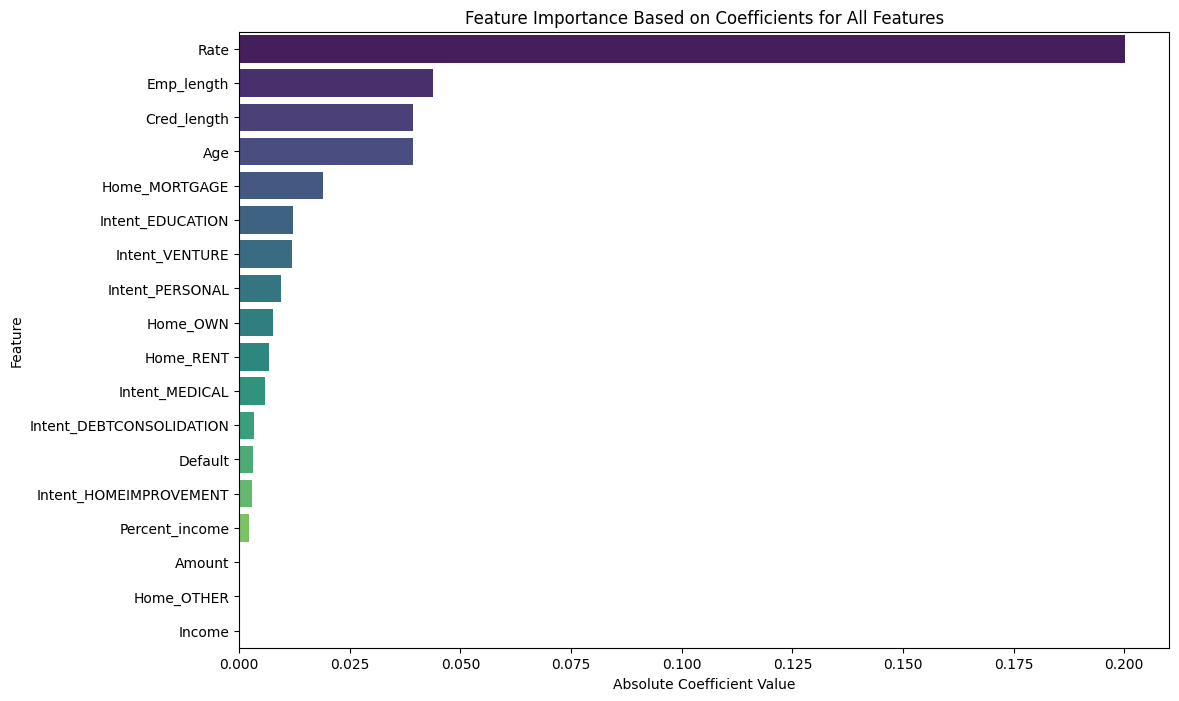

In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression


# Assume 'features' is a DataFrame and 'target' is a Series
model = LogisticRegression(max_iter=5000)


# Fit the model on the training dataset
model.fit(x_train, y_train)

# Get the feature names and coefficients
coefficients = model.coef_[0]
feature_names = x_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame by the absolute value of coefficients
importance_df['Absolute Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Absolute Coefficient', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Absolute Coefficient', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance Based on Coefficients for All Features')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

In [189]:
x_train.shape

(17831, 18)

## 8.3 Wrapper method

## Backward Elimination (wrapper method)

In [190]:
# accuracies = []
# # selecting the best combination of features
# model = LogisticRegression(max_iter=5000)
# for i in range(1, 16):
#   sfs = SequentialFeatureSelector(model, n_features_to_select=i, direction='backward')
#   sfs.fit(x_train, y_train)

#   # Transform the training and test datasets to only include selected features
#   X_train_selected = sfs.transform(x_train)
#   x_val_selected = sfs.transform(x_val)

#   # Fit the model on the selected features
#   model = LogisticRegression(max_iter=5000)
#   model.fit(X_train_selected, y_train)

#   # Predict on the test set
#   y_pred = model.predict(x_val_selected)

#   # Calculate accuracy
#   accuracy = accuracy_score(y_val, y_pred)
#   accuracies.append(accuracy)
#   print(f'Accuracy with the selected top {i} features: {accuracy:.4f}')


## Farward selection (wrapper method)

In [191]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score

accuracies = []
# selecting the best combination of features
for i in range(1, 16):
  sfs = SequentialFeatureSelector(model, n_features_to_select=i)
  sfs.fit(x_train, y_train)

  # Transform the training and test datasets to only include selected features
  X_train_selected = sfs.transform(x_train)
  x_val_selected = sfs.transform(x_val)

  # Fit the model on the selected features
  model = LogisticRegression(max_iter=5000)
  model.fit(X_train_selected, y_train)

  # Predict on the test set
  y_pred = model.predict(x_val_selected)

  # Calculate accuracy
  accuracy = accuracy_score(y_val, y_pred)
  accuracies.append(accuracy)
  print(f'Accuracy with the selected top {i} features: {accuracy:.4f}')


# print(f"the highest accuracy {max(accuracies)} gotten with the combination of {accuracies.index(max(accuracies)) + 1}  features ")

Accuracy with the selected top 1 features: 0.6697
Accuracy with the selected top 2 features: 0.7416
Accuracy with the selected top 3 features: 0.7622
Accuracy with the selected top 4 features: 0.7807
Accuracy with the selected top 5 features: 0.8072
Accuracy with the selected top 6 features: 0.8171
Accuracy with the selected top 7 features: 0.8248
Accuracy with the selected top 8 features: 0.8337
Accuracy with the selected top 9 features: 0.8384
Accuracy with the selected top 10 features: 0.8515
Accuracy with the selected top 11 features: 0.8731
Accuracy with the selected top 12 features: 0.8746
Accuracy with the selected top 13 features: 0.8742
Accuracy with the selected top 14 features: 0.8749
Accuracy with the selected top 15 features: 0.8748


In [192]:
print(f"the highest accuracy {max(accuracies)} gotten with the combination of {accuracies.index(max(accuracies)) + 1}  features ")
no_of_features_selected = accuracies.index(max(accuracies)) + 1

the highest accuracy 0.8749018581523161 gotten with the combination of 14  features 


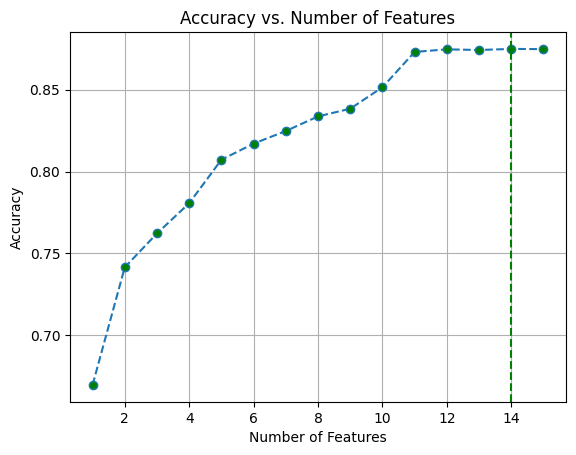

In [193]:
plt.plot(range(1, 16), accuracies, marker='o', linestyle='--', markerfacecolor='green')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Features')
plt.axvline(x=accuracies.index(max(accuracies)) + 1, color='green', linestyle='--')
plt.grid(True)

plt.show()

In [194]:

model = LogisticRegression(max_iter=5000)

sfs = SequentialFeatureSelector(model, n_features_to_select=no_of_features_selected)
sfs.fit(x_train, y_train)
# transform the usable dataset
x_use_selected = sfs.transform(x_use)
# Transform the dataset to only include selected features
x_train_selected = sfs.transform(x_train)
x_val_selected = sfs.transform(x_val)

# Transofrming The test data on only include selected featues too
x_test_selected = sfs.transform(x_test)

# Get the feature names and coefficients for the selected features
selected_feature_names = x_train.columns[sfs.get_support()]

print(selected_feature_names)



Index(['Percent_income', 'Default', 'Cred_length', 'Intent_DEBTCONSOLIDATION',
       'Intent_EDUCATION', 'Intent_HOMEIMPROVEMENT', 'Intent_MEDICAL',
       'Intent_PERSONAL', 'Intent_VENTURE', 'Home_MORTGAGE', 'Home_OTHER',
       'Home_OWN', 'Home_RENT', 'Rate'],
      dtype='object')


# 9 Model Training After feature Selection

# ◉ Logistic Regression (After Feature Selection)

## &rarr; Traing with default parameters

In [195]:
lr_model_fs=LogisticRegression(max_iter=5000)
lr_model_fs.fit(x_train_selected, y_train)

LogisticRegression(max_iter=5000)

In [196]:
y_pred = lr_model_fs.predict(x_val_selected)

In [197]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix")
print(confusion_matrix(y_val, y_pred))
print("\n Classification Report")
print(classification_report(y_val, y_pred))

Confusion matrix
[[3556  281]
 [ 675 3130]]

 Classification Report
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      3837
           1       0.92      0.82      0.87      3805

    accuracy                           0.87      7642
   macro avg       0.88      0.87      0.87      7642
weighted avg       0.88      0.87      0.87      7642



## &rarr; peforming cross validation

# Stratified K-Fold for Logistic Regression

In [337]:
skf = StratifiedKFold(n_splits=5)
lr_model_fs_skf_score = cross_val_score(lr_model_fs, x_use_selected, y_use, cv=skf)

lr_model_fs_skf_avg_score = round(lr_model_fs_skf_score.mean(),3)
print(score)
print("the Stratified k-fold sore for logistic regression model is : " , lr_model_fs_skf_score)
print("the Stratified k-fold average sore for logistic regression model is : " , lr_model_fs_skf_avg_score)

[0.73660451 0.72914622 0.7265947  0.73046722 0.73125245]
the Stratified k-fold sore for logistic regression model is :  [0.87163886 0.87634936 0.87654563 0.87416569 0.88182175]
the Stratified k-fold average sore for logistic regression model is :  0.876


## K-Fold cross validation for Logistic Regression

In [338]:
kf = KFold(n_splits=5)
lr_model_fs_kf_score = cross_val_score(lr_model_fs, x_use_selected, y_use, cv=kf)
lr_model_fs_kf_avg_score = round(lr_model_fs_kf_score.mean(),3)
print("the stratified k-fold score for linear regresion model is :", lr_model_fs_kf_score)
print("the stratified k-fold avg score for linear regresion model is :", lr_model_fs_kf_avg_score)

the stratified k-fold score for linear regresion model is : [0.87222767 0.87654563 0.8767419  0.87338045 0.88162544]
the stratified k-fold avg score for linear regresion model is : 0.876


## &rarr; Hyper parameter tunning

In [201]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr_model_fs_grid_search = GridSearchCV(lr_model_fs, param_grid, cv=5, verbose=3, scoring='accuracy')
lr_model_fs_grid_search.fit(x_train_selected, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.642 total time=   0.0s
[CV 2/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.632 total time=   0.0s
[CV 3/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.640 total time=   0.0s
[CV 4/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.629 total time=   0.0s
[CV 5/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.634 total time=   0.0s
[CV 1/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 2/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.765 total time=   0.0s
[CV 3/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.746 total time=   0.0s
[CV 4/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.739 total time=   0.0s
[CV 5/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.753 total time=   0.0s
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.853 total time=   0.1s
[CV 2/5] END C=0

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=5000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy', verbose=3)

In [202]:
lr_model_fs_best_parameters = lr_model_fs_grid_search.best_params_
print(lr_model_fs_best_parameters)

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


## &rarr; Retrain with best parameters

In [203]:
final_lr_model_fs = LogisticRegression(max_iter=5000)
final_lr_model_fs.fit(x_train_selected, y_train)

LogisticRegression(max_iter=5000)

In [204]:
y_pred = final_lr_model_fs.predict(x_val_selected)

In [205]:
final_lr_model_fs_report = classification_report(y_val, y_pred)
print(final_lr_model_fs_report)

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      3837
           1       0.92      0.82      0.87      3805

    accuracy                           0.87      7642
   macro avg       0.88      0.87      0.87      7642
weighted avg       0.88      0.87      0.87      7642



## &rarr; Evaluate on test set (Testing the model )

In [206]:
lr_fs_test_pred = final_lr_model_fs.predict(x_test_selected)

In [207]:
lr_fs_test_report = classification_report(y_test, lr_fs_test_pred)
print(lr_fs_test_report)

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      4246
           1       0.91      0.83      0.87      4245

    accuracy                           0.88      8491
   macro avg       0.88      0.88      0.88      8491
weighted avg       0.88      0.88      0.88      8491



In [208]:
lr_fs_test_accuracy = round(accuracy_score(y_test, lr_fs_test_pred),2)
lr_fs_test_recall = round(recall_score(y_test, lr_fs_test_pred),2)
lr_fs_test_precision = round(precision_score(y_test, lr_fs_test_pred),2)
lr_fs_test_f1_score = round(f1_score(y_test, lr_fs_test_pred),2)

print("accuracy : ", lr_fs_test_accuracy)
print("recall : ", lr_fs_test_recall)
print("precision : ", lr_fs_test_precision)
print("f1_score : ", lr_fs_test_f1_score)

accuracy :  0.88
recall :  0.83
precision :  0.91
f1_score :  0.87


## ◉ GaussianNB (Naive Bayes Classifier) After feature selection

In [209]:
nb_model_fs = GaussianNB()
nb_model_fs.fit(x_train_selected, y_train)


GaussianNB()

In [210]:
y_pred = nb_model_fs.predict(x_val_selected)

In [211]:
print("Confusion matrix")
print(confusion_matrix(y_val, y_pred))
print("\n Classification Report")
print(classification_report(y_val, y_pred))

Confusion matrix
[[3069  768]
 [ 618 3187]]

 Classification Report
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      3837
           1       0.81      0.84      0.82      3805

    accuracy                           0.82      7642
   macro avg       0.82      0.82      0.82      7642
weighted avg       0.82      0.82      0.82      7642



## &rarr; Peforming cross validation

## stratified K-Fold for GaussianNB

In [335]:
skf = StratifiedKFold(n_splits=5)
nb_model_fs_skf_score = cross_val_score(nb_model_fs, x_use_selected, y_use, cv=skf)
print(nb_model_fs_skf_score)
nb_model_fs_skf_avg_score = round(nb_model_fs_skf_score.mean(),3)
print("GaussianNB stratified k-fold score : ", nb_model_fs_skf_avg_score)

[0.81059863 0.81668302 0.81530913 0.81252454 0.82135846]
GaussianNB stratified k-fold score :  0.815


## K-Fold for GaussianNB

In [336]:
kf = KFold(n_splits=5)
nb_model_fs_kf_score = cross_val_score(nb_model_fs, x_use_selected, y_use, cv=kf)
print(nb_model_fs_kf_score)
nb_model_fs_kf_avg_score = round(nb_model_fs_kf_score.mean(),3)

print("the mean avg score for GausianNB kfold cross validatin is :", nb_model_fs_kf_avg_score)

[0.80902846 0.81943081 0.81216879 0.81232823 0.82332155]
the mean avg score for GausianNB kfold cross validatin is : 0.815


## &rarr; Hyper Parameter tunning

In [214]:
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

nb_model_fs_grid_search = GridSearchCV(nb_model_fs, param_grid=param_grid, verbose=3, cv=5)
nb_model_fs_grid_search.fit(x_train_selected, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...............var_smoothing=1e-09;, score=0.813 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-09;, score=0.819 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-09;, score=0.807 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-09;, score=0.813 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-09;, score=0.809 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-08;, score=0.813 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-08;, score=0.819 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-08;, score=0.807 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-08;, score=0.813 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-08;, score=0.809 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-07;, score=0.813 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-07;,

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]},
             verbose=3)

In [215]:
nb_model_fs_best_parameters = nb_model_fs_grid_search.best_params_
print(nb_model_fs_best_parameters)

{'var_smoothing': 1e-09}


## &rarr; Retrain the model with best parameters

In [216]:
final_nb_model_fs = GaussianNB(var_smoothing=nb_model_fs_best_parameters['var_smoothing'])
final_nb_model_fs.fit(x_train_selected, y_train)

GaussianNB()

In [217]:
y_pred = final_nb_model_fs.predict(x_val_selected)

In [218]:
final_nb_model_fs_report = classification_report(y_val,y_pred)
print(final_nb_model_fs_report)

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      3837
           1       0.81      0.84      0.82      3805

    accuracy                           0.82      7642
   macro avg       0.82      0.82      0.82      7642
weighted avg       0.82      0.82      0.82      7642



## &rarr; Evaluate GaussianNB model on the test set

In [219]:
nb_fs_test_pred = final_nb_model_fs.predict(x_test_selected)

In [220]:
nb_fs_test_report = classification_report(y_test, nb_fs_test_pred)
print(nb_fs_test_report)

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      4246
           1       0.80      0.83      0.82      4245

    accuracy                           0.81      8491
   macro avg       0.81      0.81      0.81      8491
weighted avg       0.81      0.81      0.81      8491



In [221]:
nb_fs_test_accuracy = round(accuracy_score(y_test, nb_fs_test_pred),2)
nb_fs_test_recall = round(recall_score(y_test, nb_fs_test_pred),2)
nb_fs_test_precision = round(precision_score(y_test, nb_fs_test_pred),2)
nb_fs_test_f1_score = round(f1_score(y_test, nb_fs_test_pred),2)

print("accuracy : ", nb_fs_test_accuracy)
print("recall : ", nb_fs_test_recall)
print("precision : ", nb_fs_test_precision)
print("f1_score : ", nb_fs_test_f1_score)

accuracy :  0.81
recall :  0.83
precision :  0.8
f1_score :  0.82


# ◉ KNeighborClassifier


In [222]:
knn_model_fs = KNeighborsClassifier()
knn_model_fs.fit(x_train_selected, y_train)

KNeighborsClassifier()

In [223]:
y_pred = knn_model_fs.predict(x_val_selected)

In [224]:
print("Confusion matrix")
print(confusion_matrix(y_val, y_pred))
print("\n Classification Report")
print(classification_report(y_val, y_pred))

Confusion matrix
[[3351  486]
 [ 782 3023]]

 Classification Report
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      3837
           1       0.86      0.79      0.83      3805

    accuracy                           0.83      7642
   macro avg       0.84      0.83      0.83      7642
weighted avg       0.84      0.83      0.83      7642



## &rarr; peforming cross-validation

## stratified K-Fold for KNN

In [315]:
st = time.time()
skf = StratifiedKFold(n_splits=5)
knn_model_fs_skf_score = cross_val_score(knn_model_fs, x_use_selected, y_use, cv=skf)
knn_model_fs_skf_avg_score = knn_model_fs_skf_score.mean()
et = time.time()
print("time taken for stratified kfold cross validation on KNN is: ", et-st)
print("the stratified  k-fold score for knn model is :", knn_model_fs_skf_score)
print("the stratified k-fold avg score for knn model is :", knn_model_fs_skf_avg_score)

time taken for stratified kfold cross validation on KNN is:  2.1280593872070312
the stratified  k-fold score for knn model is : [0.84416094 0.8390579  0.84965653 0.84020416 0.85669415]
the stratified k-fold avg score for knn model is : 0.8459547359494304


## K-Fold cross validation for KNN

In [316]:
st = time.time()
kfold = KFold(n_splits=5)
knn_model_kf_score = cross_val_score(knn_model_fs, x_use, y_use, cv=kfold)
knn_model_fs_kf_avg_score = knn_model_kf_score.mean()
et = time.time()
print("time taken for kfold crossvalidaton: ", et-st)
print("the k-fold score for knn model is :", knn_model_kf_score)
print("the k-fold avg score for knn model is :", knn_model_fs_kf_avg_score)

time taken for kfold crossvalidaton:  4.136526107788086
the k-fold score for knn model is : [0.80019627 0.80588813 0.79116781 0.79564193 0.80113859]
the k-fold avg score for knn model is : 0.7988065468312506


## &rarr; Hyper parameter tunning (KNeighborClassifier)

In [226]:
param_grid={
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_model_fs_grid_search = GridSearchCV(knn_model_fs, param_grid=param_grid, verbose=3, cv=5)
knn_model_fs_grid_search.fit(x_train_selected, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END n_neighbors=3, p=1, weights=uniform;, score=0.847 total time=   0.3s
[CV 2/5] END n_neighbors=3, p=1, weights=uniform;, score=0.844 total time=   0.3s
[CV 3/5] END n_neighbors=3, p=1, weights=uniform;, score=0.846 total time=   0.3s
[CV 4/5] END n_neighbors=3, p=1, weights=uniform;, score=0.849 total time=   0.3s
[CV 5/5] END n_neighbors=3, p=1, weights=uniform;, score=0.840 total time=   0.3s
[CV 1/5] END n_neighbors=3, p=1, weights=distance;, score=0.846 total time=   0.1s
[CV 2/5] END n_neighbors=3, p=1, weights=distance;, score=0.840 total time=   0.1s
[CV 3/5] END n_neighbors=3, p=1, weights=distance;, score=0.845 total time=   0.1s
[CV 4/5] END n_neighbors=3, p=1, weights=distance;, score=0.850 total time=   0.1s
[CV 5/5] END n_neighbors=3, p=1, weights=distance;, score=0.840 total time=   0.1s
[CV 1/5] END n_neighbors=3, p=2, weights=uniform;, score=0.839 total time=   0.3s
[CV 2/5] END n_neighbors=3, p=2

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [227]:
knn_fs_best_parameters = knn_model_fs_grid_search.best_params_
print(f"the best parameters for the knn model are : {knn_fs_best_parameters}")

the best parameters for the knn model are : {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}


## &rarr; Retrain with best parameters

In [228]:
final_knn_model_fs = KNeighborsClassifier(n_neighbors=knn_fs_best_parameters['n_neighbors'], p=knn_fs_best_parameters['p'], weights=knn_fs_best_parameters['weights'])
final_knn_model_fs.fit(x_train_selected, y_train)

KNeighborsClassifier(n_neighbors=11, p=1, weights='distance')

In [229]:
y_pred = final_knn_model_fs.predict(x_val_selected)

In [230]:
final_knn_model_fs_report = classification_report(y_val, y_pred)
print(final_knn_model_fs_report)

              precision    recall  f1-score   support

           0       0.82      0.89      0.86      3837
           1       0.88      0.80      0.84      3805

    accuracy                           0.85      7642
   macro avg       0.85      0.85      0.85      7642
weighted avg       0.85      0.85      0.85      7642



## &rarr; evaluate on test set (Testing the model)

In [231]:
knn_fs_test_pred = final_knn_model_fs.predict(x_test_selected)

In [232]:
knn_fs_test_report = classification_report(y_test, knn_fs_test_pred)
accuracy = accuracy_score(y_test, knn_fs_test_pred)
print("accuracy : ", accuracy)
print(knn_fs_test_report)

accuracy :  0.8525497585678954
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4246
           1       0.88      0.82      0.85      4245

    accuracy                           0.85      8491
   macro avg       0.85      0.85      0.85      8491
weighted avg       0.85      0.85      0.85      8491



In [233]:
knn_fs_test_accuracy = round(accuracy_score(y_test, knn_fs_test_pred),2)
knn_fs_test_recall = round(recall_score(y_test, knn_fs_test_pred),2)
knn_fs_test_precision = round(precision_score(y_test, knn_fs_test_pred),2)
knn_fs_test_f1_score = round(f1_score(y_test, knn_fs_test_pred),2)

print("accuracy : ", knn_fs_test_accuracy)
print("recall : ", knn_fs_test_recall)
print("precision : ", knn_fs_test_precision)
print("f1_score : ", knn_fs_test_f1_score)

accuracy :  0.85
recall :  0.82
precision :  0.88
f1_score :  0.85


# ◉ DecissionTreeClassifier (After Feature selection)

In [234]:
dt_model_fs = DecisionTreeClassifier()
dt_model_fs.fit(x_train_selected, y_train)

DecisionTreeClassifier()

In [235]:
y_pred = dt_model_fs.predict(x_val_selected)

In [236]:
print("Confusion matrix")
print(confusion_matrix(y_val, y_pred))
print("\n Classification Report")
print(classification_report(y_val, y_pred))

Confusion matrix
[[3310  527]
 [ 497 3308]]

 Classification Report
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      3837
           1       0.86      0.87      0.87      3805

    accuracy                           0.87      7642
   macro avg       0.87      0.87      0.87      7642
weighted avg       0.87      0.87      0.87      7642



## &rarr; peforming cross-validation

## stratified k-Fold for Decision Tree Classifier

In [334]:
# skf stands for Stratified K-Fold
st = time.time()
skf = StratifiedKFold(n_splits=5)
dt_model_fs_skf_score = cross_val_score(dt_model_fs, x_use_selected, y_use, cv=skf)
et = time.time()
dt_model_fs_skf_avg_score = round(dt_model_fs_skf_score.mean(),3)
print("Decision tree skf  average score : ", dt_model_fs_skf_avg_score)
print(dt_model_fs_skf_score)
print("time taken to do k-fold cross validation for decisionTree : ", et-st)

Decision tree skf  average score :  0.869
[0.86476938 0.86437684 0.87654563 0.86258343 0.87632509]
time taken to do k-fold cross validation for decisionTree :  0.35951852798461914


## K-Fold cross validation for Desision Tree Classifier

In [333]:
# kf stands for K-Fold
st = time.time()
kf = KFold(n_splits=5)
dt_model_fs_kf_score = cross_val_score(dt_model_fs, x_use_selected, y_use, cv=kf)
et = time.time()
print(dt_model_fs_kf_score)
dt_model_fs_kf_avg_score = round(dt_model_fs_kf_score.mean(),3)
print("Decision tree kf average score : ", dt_model_fs_kf_avg_score)
print("time taken to do  cross validation for decisionTree : ", et-st)

[0.86614328 0.86810599 0.87262022 0.86415391 0.8745583 ]
Decision tree kf average score :  0.869
time taken to do  cross validation for decisionTree :  0.3497767448425293


## &rarr; Hyper parameter tunning

In [239]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

dt_model_fs_grid_search = GridSearchCV(dt_model_fs, param_grid=param_grid, verbose=3, cv=5)
dt_model_fs_grid_search.fit(x_train_selected, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.872 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.865 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.868 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.874 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.868 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.879 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.873 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.881 total time=  

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=3)

In [240]:
dt_model_fs_best_parameters = dt_model_fs_grid_search.best_params_
print(f"the best parameters for the decision tree model are : {dt_model_fs_best_parameters}")

the best parameters for the decision tree model are : {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}


## &rarr; Retrain the model with best parameters

In [241]:
final_dt_model_fs = DecisionTreeClassifier(criterion=dt_model_fs_best_parameters['criterion'], max_depth= dt_model_fs_best_parameters['max_depth'], min_samples_leaf=dt_model_fs_best_parameters['min_samples_leaf'], min_samples_split=dt_model_fs_best_parameters['min_samples_split'])
final_dt_model_fs.fit(x_train_selected, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2)

In [242]:
y_pred = final_dt_model_fs.predict(x_val_selected)

In [243]:
final_dt_report = classification_report(y_val, y_pred)
print(final_dt_report)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3837
           1       0.94      0.82      0.88      3805

    accuracy                           0.89      7642
   macro avg       0.89      0.89      0.89      7642
weighted avg       0.89      0.89      0.89      7642



## &rarr; Evaluate on Test set (Testing the Decision tree model)

In [244]:
dt_fs_test_pred = final_dt_model_fs.predict(x_test_selected)

In [245]:
dt_fs_test_report = classification_report(y_test, dt_fs_test_pred)
accuracy = accuracy_score(y_test, dt_fs_test_pred)
print("accuracy : ", accuracy)
print(dt_fs_test_report)

accuracy :  0.8929454716758921
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      4246
           1       0.94      0.84      0.89      4245

    accuracy                           0.89      8491
   macro avg       0.90      0.89      0.89      8491
weighted avg       0.90      0.89      0.89      8491



In [247]:
fdt_fs_test_accuracy = round(accuracy_score(y_test, dt_fs_test_pred),2)
dt_fs_test_recall = round(recall_score(y_test, dt_fs_test_pred),2)
dt_fs_test_precision = round(precision_score(y_test, dt_fs_test_pred),2)
dt_fs_test_f1_score = round(f1_score(y_test, dt_fs_test_pred),2)

print("accuracy : ", dt_fs_test_accuracy)
print("recall : ", dt_fs_test_recall)
print("precision : ", dt_fs_test_precision)
print("f1_score : ", dt_fs_test_f1_score)

accuracy :  0.89
recall :  0.84
precision :  0.94
f1_score :  0.89


# ◉Support Vector Classifier

In [248]:
svc_model_fs = SVC()
svc_model_fs.fit(x_train_selected, y_train)

SVC()

In [249]:
y_pred = svc_model_fs.predict(x_val_selected)

In [250]:
print("Confusion matrix")
print(confusion_matrix(y_val, y_pred))
print("\n Classification Report")
print(classification_report(y_val, y_pred))

Confusion matrix
[[3643  194]
 [ 964 2841]]

 Classification Report
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      3837
           1       0.94      0.75      0.83      3805

    accuracy                           0.85      7642
   macro avg       0.86      0.85      0.85      7642
weighted avg       0.86      0.85      0.85      7642



## &rarr; Peforming cross-validation

## stratified K-fold for SVC

In [331]:
st = time.time()
skf = StratifiedKFold(n_splits=5)
svc_model_fs_skf_score = cross_val_score(svc_model_fs, x_use_selected, y_use, cv=skf)
svc_model_fs_skf_avg_score = round(svc_model_fs_skf_score.mean(),3)
et = time.time()
print("time taken for stratified kfold cross validation on SVC is: ", et-st)
print(svc_model_fs_skf_score)
print("the mean avg score for SVC kfold cross validatin is :", svc_model_fs_skf_avg_score)


time taken for stratified kfold cross validation on SVC is:  80.10190153121948
[0.85397448 0.85397448 0.86162905 0.85257165 0.86631331]
the mean avg score for SVC kfold cross validatin is : 0.858


## K-Fold cross vallidation for SVC

In [332]:
st = time.time()
kf = KFold(n_splits=5)
svc_model_fs_kf_score = cross_val_score(svc_model_fs, x_use_selected, y_use, cv=kf)
svc_model_fs_kf_avg_score = round(svc_model_fs_kf_score.mean(),3)
print(svc_model_fs_kf_score)
print("the mean avg score for SVC kfold cross validatin is :", svc_model_fs_kf_avg_score)
et = time.time()
print("time taken for kfold crossvalidaton: ", et-st)
print(score)

[0.85593719 0.85122669 0.86653582 0.85041225 0.86238712]
the mean avg score for SVC kfold cross validatin is : 0.857
time taken for kfold crossvalidaton:  83.27007937431335
[0.73660451 0.72914622 0.7265947  0.73046722 0.73125245]


## &rarr; Hyper parameter tunning

In [253]:
# commented it out because is taking too long to execute
param_grid = {
    'C': [0.1, 1, 5, 10, 15, 20],
}

svc_model_fs_grid_search = GridSearchCV(svc_model_fs, param_grid=param_grid, verbose=3, cv=5)
svc_model_fs_grid_search.fit(x_train_selected, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .............................C=0.1;, score=0.763 total time=  13.7s
[CV 2/5] END .............................C=0.1;, score=0.774 total time=  14.4s
[CV 3/5] END .............................C=0.1;, score=0.764 total time=  14.5s
[CV 4/5] END .............................C=0.1;, score=0.767 total time=  13.9s
[CV 5/5] END .............................C=0.1;, score=0.769 total time=  13.8s
[CV 1/5] END ...............................C=1;, score=0.853 total time=   8.6s
[CV 2/5] END ...............................C=1;, score=0.851 total time=   9.9s
[CV 3/5] END ...............................C=1;, score=0.856 total time=   7.6s
[CV 4/5] END ...............................C=1;, score=0.865 total time=   9.8s
[CV 5/5] END ...............................C=1;, score=0.853 total time=   8.6s
[CV 1/5] END ...............................C=5;, score=0.871 total time=   7.5s
[CV 2/5] END ...............................C=5;,

GridSearchCV(cv=5, estimator=SVC(), param_grid={'C': [0.1, 1, 5, 10, 15, 20]},
             verbose=3)

In [254]:
svc_model_fs_best_parameters = svc_model_fs_grid_search.best_params_
print(svc_model_fs_best_parameters)

{'C': 20}


In [255]:
final_svc_model_fs = SVC(C=svc_model_fs_best_parameters['C'])
final_svc_model_fs.fit(x_train_selected, y_train)

SVC(C=20)

In [256]:
y_pred = final_svc_model_fs.predict(x_val_selected)

In [257]:
final_svc_model_fs_report = classification_report(y_val, y_pred)
print(final_svc_model_fs_report)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3837
           1       0.94      0.82      0.88      3805

    accuracy                           0.88      7642
   macro avg       0.89      0.88      0.88      7642
weighted avg       0.89      0.88      0.88      7642



## &rarr; Evaluate on test set (Testing the SVC model)

In [258]:
svc_fs_test_pred = final_svc_model_fs.predict(x_test_selected)

In [259]:
svc_fs_test_report = classification_report(y_test, svc_fs_test_pred)
print(svc_fs_test_report)

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4246
           1       0.94      0.83      0.88      4245

    accuracy                           0.89      8491
   macro avg       0.89      0.89      0.89      8491
weighted avg       0.89      0.89      0.89      8491



In [260]:
svc_fs_test_accracy = round(accuracy_score(y_test, svc_fs_test_pred),2)
svc_fs_test_recall = round(recall_score(y_test, svc_fs_test_pred),2)
svc_fs_test_precision = round(precision_score(y_test, svc_fs_test_pred),2)
svc_fs_test_f1_score = round(f1_score(y_test, svc_fs_test_pred),2)

print("accuracy : ", svc_fs_test_accracy)
print("recall : ", svc_fs_test_recall)
print("precision : ", svc_fs_test_precision)
print("f1_score : ", svc_fs_test_f1_score)

accuracy :  0.89
recall :  0.83
precision :  0.94
f1_score :  0.88


# ● Ensemble Models

## ◉ Bagging Classifier

In [261]:
bagging_fs = BaggingClassifier()
bagging_fs.fit(x_train_selected, y_train)

BaggingClassifier()

In [262]:
y_pred = bagging_fs.predict(x_val_selected)

In [263]:
print("Confusion matrix")
print(confusion_matrix(y_val, y_pred))
print("\n Classification Report")
print(classification_report(y_val, y_pred))

Confusion matrix
[[3597  240]
 [ 577 3228]]

 Classification Report
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3837
           1       0.93      0.85      0.89      3805

    accuracy                           0.89      7642
   macro avg       0.90      0.89      0.89      7642
weighted avg       0.90      0.89      0.89      7642



## &rarr; Peforming Cross-Validation

## KFold cross validation for BaggingClassifier

In [264]:
st = time.time()
kf = KFold(n_splits=5)
bagging_fs_kf_score = cross_val_score(bagging_fs, x_use_selected, y_use, cv=kf)
bagging_fs_kf_avg_score = round(bagging_fs_kf_score.mean(),3)
et = time.time()
print("time taken for kfold cross validation on Bagging Classifier after feature selection is: ", et-st)
print(bagging_fs_kf_score)
print("the mean avg score for Bagging Classifier kfold cross validatin after feature selection is :", bagging_fs_kf_avg_score)

time taken for kfold cross validation on Bagging Classifier after feature selection is:  2.4542627334594727
[0.89793916 0.89793916 0.89892051 0.89399293 0.90832352]
the mean avg score for Bagging Classifier kfold cross validatin after feature selection is : 0.8994230546202443


## Stratified K-Fold for BaggingClassifier

In [265]:
st = time.time()
skf = StratifiedKFold(n_splits=5)
bagging_fs_skf_score = cross_val_score(bagging_fs, x_use_selected, y_use, cv=skf)
bagging_fs_skf_avg_score = round(bagging_fs_skf_score.mean(),3)
et = time.time()
print("time taken for stratified kfold cross validation on Bagging Classifier after feature selection is: ", et-st)
print(bagging_fs_skf_score)
print("the mean avg score for Bagging Classifier kfold cross validatin after feature selection is :", bagging_fs_skf_avg_score)

time taken for stratified kfold cross validation on Bagging Classifier after feature selection is:  2.5126733779907227
[0.89597645 0.90049068 0.8983317  0.89517079 0.90557519]
the mean avg score for Bagging Classifier kfold cross validatin after feature selection is : 0.8991089596065027


## &rarr; Hyper Parameter tunning for BaggingClassifier

In [266]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
}

bagging_fs_grid_search = GridSearchCV(bagging_fs, param_grid=param_grid, cv=5)
bagging_fs_grid_search.fit(x_train_selected, y_train)

GridSearchCV(cv=5, estimator=BaggingClassifier(),
             param_grid={'max_features': [0.5, 0.7, 1.0],
                         'max_samples': [0.5, 0.7, 1.0],
                         'n_estimators': [50, 100, 200]})

In [267]:
bagging_fs_best_parameters = bagging_fs_grid_search.best_params_
print(bagging_fs_best_parameters)

{'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 100}


In [268]:
# i will retain the best params from the Bagging classifier below since it takes time to run
bagging_fs_best_parameters = {'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 200}
print(bagging_fs_best_parameters)

{'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 200}


## &rarr; Retrain the Bagging Classifier with best parameters

In [269]:
final_bagging_model_fs = BaggingClassifier(n_estimators=bagging_fs_best_parameters['n_estimators'], max_samples=bagging_fs_best_parameters['max_samples'], max_features=bagging_fs_best_parameters['max_features'])
final_bagging_model_fs.fit(x_train_selected, y_train)

BaggingClassifier(max_features=0.5, max_samples=0.7, n_estimators=200)

In [270]:
y_pred = final_bagging_model_fs.predict(x_val_selected)

In [271]:
final_bagging_model_fs_report = classification_report(y_val, y_pred)
print(final_bagging_model_fs_report)

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      3837
           1       0.96      0.85      0.90      3805

    accuracy                           0.91      7642
   macro avg       0.91      0.91      0.91      7642
weighted avg       0.91      0.91      0.91      7642



## &rarr; Evaluate on test set (Testing the model )

In [272]:
bagging_fs_test_pred = final_bagging_model_fs.predict(x_test_selected)

In [273]:
bagging_fs_test_report = classification_report(y_test, bagging_fs_test_pred)
print(bagging_fs_test_report)

              precision    recall  f1-score   support

           0       0.87      0.96      0.92      4246
           1       0.96      0.86      0.91      4245

    accuracy                           0.91      8491
   macro avg       0.92      0.91      0.91      8491
weighted avg       0.92      0.91      0.91      8491



In [274]:
bagging_fs_test_accuracy = round(accuracy_score(y_test, bagging_fs_test_pred),2)
bagging_fs_test_recall = round(recall_score(y_test, bagging_fs_test_pred),2)
bagging_fs_test_precision = round(precision_score(y_test, bagging_fs_test_pred),2)
bagging_fs_test_f1_score = round(f1_score(y_test, bagging_fs_test_pred),2)

print("accuracy : ", bagging_fs_test_accuracy)
print("recall : ", bagging_fs_test_recall)
print("precision : ", bagging_fs_test_precision)
print("f1_score : ", bagging_fs_test_f1_score)

accuracy :  0.91
recall :  0.86
precision :  0.96
f1_score :  0.91


## ◉ RandomForestClassifier

In [275]:
rf_model_fs = RandomForestClassifier()
rf_model_fs.fit(x_train_selected, y_train)

RandomForestClassifier()

In [276]:
y_pred = rf_model_fs.predict(x_val_selected)

In [277]:
print("Confusion matrix")
print(confusion_matrix(y_val, y_pred))
print("\n Classification Report")
print(classification_report(y_val, y_pred))

Confusion matrix
[[3594  243]
 [ 518 3287]]

 Classification Report
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      3837
           1       0.93      0.86      0.90      3805

    accuracy                           0.90      7642
   macro avg       0.90      0.90      0.90      7642
weighted avg       0.90      0.90      0.90      7642



## &rarr; Peforming cross- validation

## Stratified K-Fold for Random Forest Classifier

In [278]:
st = time.time()
skf = StratifiedKFold(n_splits=5)
rf_model_fs_skf_score = cross_val_score(rf_model_fs, x_use, y_use, cv=skf)
rf_model_fs_skf_avg_score = round(rf_model_skf_score.mean(),2)
et = time.time()
print("time taken for stratified kfold cross validation on Random Forest is: ", et-st)
print(rf_model_fs_skf_score)
print("the mean avg score for Random Forest Classifier kfold cross validatin is :", rf_model_fs_skf_avg_score)
print(score)

time taken for stratified kfold cross validation on Random Forest is:  17.25505542755127
[0.9373896  0.93680079 0.93640824 0.92873969 0.93953671]
the mean avg score for Random Forest Classifier kfold cross validatin is : 0.9362067170559527
[0.73660451 0.72914622 0.7265947  0.73046722 0.73125245]


In [279]:
st = time.time()
kf = KFold(n_splits=5)
rf_model_fs_kf_score = cross_val_score(rf_model_fs, x_use, y_use, cv=kf)
rf_model_fs_kf_avg_score = round(rf_model_fs_kf_score.mean(),3)
et = time.time()
print("time taken for kfold cross validation on Random Forest is: ", et-st)
print(rf_model_fs_kf_score)
print("the mean avg score for Random Forest Classifier kfold cross validatin is :", rf_model_fs_kf_avg_score)


time taken for kfold cross validation on Random Forest is:  17.496190547943115
[0.93856722 0.93797841 0.93994112 0.92756184 0.9393404 ]
the mean avg score for Random Forest Classifier kfold cross validatin is : 0.9366777979288685


In [280]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],

}

rf_model_fs_grid_search = GridSearchCV(rf_model_fs, param_grid=param_grid, verbose=3, cv=5)
rf_model_fs_grid_search.fit(x_train_selected, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...max_depth=None, n_estimators=50;, score=0.910 total time=   1.1s
[CV 2/5] END ...max_depth=None, n_estimators=50;, score=0.904 total time=   1.1s
[CV 3/5] END ...max_depth=None, n_estimators=50;, score=0.907 total time=   0.9s
[CV 4/5] END ...max_depth=None, n_estimators=50;, score=0.909 total time=   0.7s
[CV 5/5] END ...max_depth=None, n_estimators=50;, score=0.903 total time=   0.7s
[CV 1/5] END ..max_depth=None, n_estimators=100;, score=0.909 total time=   1.4s
[CV 2/5] END ..max_depth=None, n_estimators=100;, score=0.903 total time=   1.4s
[CV 3/5] END ..max_depth=None, n_estimators=100;, score=0.911 total time=   1.5s
[CV 4/5] END ..max_depth=None, n_estimators=100;, score=0.907 total time=   1.4s
[CV 5/5] END ..max_depth=None, n_estimators=100;, score=0.906 total time=   1.4s
[CV 1/5] END ..max_depth=None, n_estimators=200;, score=0.907 total time=   3.5s
[CV 2/5] END ..max_depth=None, n_estimators=200;

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [50, 100, 200]},
             verbose=3)

In [281]:
rf_model_fs_best_parameters = rf_model_fs_grid_search.best_params_
print(rf_model_fs_best_parameters)

{'max_depth': 20, 'n_estimators': 200}


In [282]:
# since fine tunning the random forest model takes a long time aroung 40minutes i decided to just save the best parameters to use when needed to avoid running the tunning again
rf_model_fs_best_parameters = {'max_depth': 20, 'n_estimators': 200}
print(rf_model_fs_best_parameters)

{'max_depth': 20, 'n_estimators': 200}


In [283]:
final_rf_model_fs = RandomForestClassifier(n_estimators=rf_model_fs_best_parameters['n_estimators'], max_depth=rf_model_fs_best_parameters['max_depth'])
final_rf_model_fs.fit(x_train_selected, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200)

In [284]:
y_pred = final_rf_model_fs.predict(x_val_selected)

In [285]:
final_rf_model_fs_report = classification_report(y_val, y_pred)
print(final_rf_model_fs_report)

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      3837
           1       0.94      0.86      0.90      3805

    accuracy                           0.90      7642
   macro avg       0.90      0.90      0.90      7642
weighted avg       0.90      0.90      0.90      7642



## &rarr; Evaluate on test set (Testing the model )

In [286]:
rf_fs_test_pred = final_rf_model_fs.predict(x_test_selected)

In [287]:
rf_fs_test_report = classification_report(y_test, rf_test_pred)
print(rf_fs_test_report)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4246
           1       0.97      0.90      0.93      4245

    accuracy                           0.93      8491
   macro avg       0.94      0.93      0.93      8491
weighted avg       0.94      0.93      0.93      8491



In [288]:
rf_fs_test_accuracy = round(accuracy_score(y_test, rf_fs_test_pred),2)
rf_fs_test_recall = round(recall_score(y_test, rf_fs_test_pred),2)
rf_fs_test_precision = round(precision_score(y_test, rf_fs_test_pred),2)
rf_fs_test_f1_score = round(f1_score(y_test, rf_fs_test_pred),2)

print("accuracy : ", rf_fs_test_accuracy)
print("recall : ", rf_fs_test_recall)
print("precision : ", rf_fs_test_precision)
print("f1_score : ", rf_fs_test_f1_score)

accuracy :  0.91
recall :  0.87
precision :  0.94
f1_score :  0.9


## ◉ XGBClassifier

In [289]:
xgb_fs = XGBClassifier()
xgb_fs.fit(x_train_selected, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [290]:
y_pred = xgb_fs.predict(x_val_selected)

In [291]:
print("Confusion matrix")
print(confusion_matrix(y_val, y_pred))
print("\n Classification Report")
print(classification_report(y_val, y_pred))

Confusion matrix
[[3670  167]
 [ 540 3265]]

 Classification Report
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      3837
           1       0.95      0.86      0.90      3805

    accuracy                           0.91      7642
   macro avg       0.91      0.91      0.91      7642
weighted avg       0.91      0.91      0.91      7642



## &rarr; Peforming cross-validation

## Stratified k-Fold for XGBClassifier

In [292]:
st = time.time()
skf = StratifiedKFold(n_splits=5)
xgb_fs_skf_score = cross_val_score(xgb_fs, x_use_selected, y_use, cv=skf)
xgb_fs_skf_avg_score = round(xgb_fs_skf_score.mean(),3)
et = time.time()
print("time taken for stratified kfold cross validation on XGBClassifier after feature selection  is: ", et-st)
print(xgb_fs_skf_score)
print("the mean avg score for XGBClassifier kfold cross validatin after feature selection  is :", xgb_fs_skf_avg_score)

time taken for stratified kfold cross validation on XGBClassifier after feature selection  is:  1.3557183742523193
[0.91187439 0.91050049 0.91462218 0.90969768 0.92010208]
the mean avg score for XGBClassifier kfold cross validatin after feature selection  is : 0.9133593640731865


## K-Fold Cross validation for XGBClassifier

In [293]:
st = time.time()
kf = KFold(n_splits=5)
xgb_fs_kf_score = cross_val_score(xgb_fs, x_use_selected, y_use, cv=kf)
xgb_fs_kf_avg_score = round(xgb_kf_score.mean(),3)
et = time.time()
print("time taken for kfold cross validation on XGBClassifier is: ", et-st)
print(xgb_fs_kf_score)
print("the mean avg score for XGBClassifier kfold cross validatin is :", xgb_fs_kf_avg_score)

time taken for kfold cross validation on XGBClassifier is:  1.2286701202392578
[0.91128557 0.90932287 0.91992149 0.90969768 0.9204947 ]
the mean avg score for XGBClassifier kfold cross validatin is : 0.9441760457857443


## &rarr; Hyper parameter Tunning

In [294]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],

}

xgb_fs_grid_search = GridSearchCV(estimator=xgb_fs, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_fs_grid_search.fit(x_train_selected, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [295]:
xgb_fs_best_parameters = xgb_fs_grid_search.best_params_
print(xgb_fs_best_parameters)

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}


In [296]:
# xgb_fs_best_parameters = {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
# print(xgb_fs_best_parameters)

## &rarr; Retrain with best parameter

In [297]:
final_xgb_model_fs = XGBClassifier(n_estimators=xgb_fs_best_parameters['n_estimators'], learning_rate=xgb_fs_best_parameters['learning_rate'], max_depth=xgb_fs_best_parameters['max_depth'])
final_xgb_model_fs.fit(x_train_selected, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [298]:
y_pred = final_xgb_model_fs.predict(x_val_selected)

In [299]:
final_xgb_model_report = classification_report(y_val, y_pred)
print(final_xgb_model_report)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      3837
           1       0.95      0.86      0.90      3805

    accuracy                           0.91      7642
   macro avg       0.91      0.91      0.91      7642
weighted avg       0.91      0.91      0.91      7642



## &rarr; Evaluate on Test set (Testing)

In [300]:
xgb_fs_test_pred = final_xgb_model_fs.predict(x_test_selected)

In [301]:
xgb_fs_test_report = classification_report(y_test, xgb_fs_test_pred)
print(xgb_fs_test_report)

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      4246
           1       0.95      0.87      0.91      4245

    accuracy                           0.91      8491
   macro avg       0.92      0.91      0.91      8491
weighted avg       0.92      0.91      0.91      8491



In [302]:
xgb_fs_test_accuracy = round(accuracy_score(y_test, xgb_fs_test_pred),2)
xgb_fs_test_recall = round(recall_score(y_test, xgb_fs_test_pred),2)
xgb_fs_test_precision = round(precision_score(y_test, xgb_fs_test_pred),2)
xgb_fs_test_f1_score = round(f1_score(y_test, xgb_fs_test_pred),2)

print("accuracy : ", xgb_fs_test_accuracy)
print("recall : ", xgb_fs_test_recall)
print("precision : ", xgb_fs_test_precision)
print("f1_score : ", xgb_fs_test_f1_score)

accuracy :  0.91
recall :  0.87
precision :  0.95
f1_score :  0.91


## ◉ Stacking Classifier

## &rarr; Traing with default parameters

In [310]:

st = time.time()
level0 = list()
level0.append(('lr', final_lr_model_fs ))
level0.append(('knn', final_knn_model_fs ))
level0.append(('Dtree', final_dt_model_fs ))
level0.append(('svm', final_svc_model_fs ))
level0.append(('rf', final_rf_model_fs ))
level0.append(('bagging', final_bagging_model_fs ))


level1 = XGBClassifier()

stacking_model_fs = StackingClassifier(estimators=level0, final_estimator=level1)
stacking_model_fs.fit(x_train_selected, y_train)

et = time.time()
print("time taken for stacking classifier is : ", et-st)
stacking_model_fs

time taken for stacking classifier is :  124.5575020313263


StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=5000)),
                               ('knn',
                                KNeighborsClassifier(n_neighbors=11, p=1,
                                                     weights='distance')),
                               ('Dtree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=10,
                                                       min_samples_leaf=2)),
                               ('svm', SVC(C=20)),
                               ('rf',
                                RandomForestClassifier(max_depth=20,
                                                       n_estimators=200)),
                               ('bagging',
                                BaggingClassifier(max_features=0.5...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...))

In [311]:
y_pred = stacking_model_fs.predict(x_val_selected)

In [312]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      3837
           1       0.96      0.87      0.91      3805

    accuracy                           0.91      7642
   macro avg       0.92      0.91      0.91      7642
weighted avg       0.92      0.91      0.91      7642



## &rarr; peform Cross validation for the stacking model

## kFold cross validation

In [329]:
kf = KFold(n_splits=5)
stacking_fs_kf_score = cross_val_score(stacking_model_fs, x_use_selected, y_use, cv=kf)
stacking_fs_kf_avg_score = round(stacking_fs_kf_score.mean(),3)
print(stacking_fs_kf_score)
print("the mean avg score for Stacking Classifier kfold cross validatin after feature selection is :", stacking_fs_kf_avg_score)

[0.91776251 0.91697743 0.92031403 0.91499804 0.92127994]
the mean avg score for Stacking Classifier kfold cross validatin after feature selection is : 0.91826638971439


## Stratified KFold cross validation

In [330]:
skf = StratifiedKFold(n_splits=5)
stacking_fs_skf_score = cross_val_score(stacking_model_fs, x_use_selected, y_use, cv=skf)
stacking_fs_skf_avg_score = round(stacking_fs_skf_score.mean(),3)
print(stacking_fs_skf_score)
print("the mean avg score for Stacking Classifier stratified kfold cross validatin after feature selection is :", stacking_fs_skf_avg_score)

[0.91795878 0.91560353 0.91913641 0.91166078 0.92520612]
the mean avg score for Stacking Classifier stratified kfold cross validatin after feature selection is : 0.9179131252954755


## &rarr; Hyper parameter Tunning

#### for Stacking i used the already hypertuned models above so there is no need tunning the models again

## &rarr; Retrain with best parameter

In [306]:
# In this case the originally trained stacking model above will be used as the final stacking model
final_stacking_model_fs = stacking_model_fs

## &rarr; Evaluate on Test set (Testing)

In [307]:
stacking_fs_test_pred = final_stacking_model_fs.predict(x_test_selected)

In [308]:
stacking_fs_test_report = classification_report(y_test, stacking_fs_test_pred)
print(stacking_fs_test_report)

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      4246
           1       0.95      0.87      0.91      4245

    accuracy                           0.92      8491
   macro avg       0.92      0.92      0.92      8491
weighted avg       0.92      0.92      0.92      8491



In [309]:
stacking_fs_test_accuracy = round(accuracy_score(y_test, stacking_fs_test_pred),2)
stacking_fs_test_recall = round(recall_score(y_test, stacking_fs_test_pred),2)
stacking_fs_test_precision = round(precision_score(y_test, stacking_fs_test_pred),2)
stacking_fs_test_f1_score = round(f1_score(y_test,stacking_fs_test_pred),2)

print("accuracy : ", stacking_fs_test_accuracy)
print("recall : ", stacking_fs_test_recall)
print("precision : ", stacking_fs_test_precision)
print("f1_score : ", stacking_fs_test_f1_score)

accuracy :  0.92
recall :  0.87
precision :  0.95
f1_score :  0.91


In [328]:
import plotly.graph_objects as go
model_names = ['KNN', 'DTC', 'Logistic R', 'Naive B', 'SVC', 'Random F', 'Bagging', 'XGB', 'Stacking']
precision_values = [knn_fs_test_precision, dt_fs_test_precision, lr_fs_test_precision, nb_fs_test_precision, svc_fs_test_precision,rf_fs_test_precision, bagging_fs_test_precision , xgb_fs_test_precision, stacking_fs_test_precision]
recall_values = [knn_fs_test_recall, dt_fs_test_recall, lr_fs_test_recall, nb_fs_test_recall, svc_fs_test_recall, rf_fs_test_recall, bagging_fs_test_recall, xgb_test_recall, stacking_fs_test_recall]
f1_score_values = [knn_fs_test_f1_score, dt_fs_test_f1_score, lr_fs_test_f1_score, nb_fs_test_f1_score, svc_fs_test_f1_score, rf_fs_test_f1_score, bagging_fs_test_f1_score, xgb_fs_test_f1_score, stacking_fs_test_f1_score]
kf_cv_values = [knn_model_fs_kf_avg_score, dt_model_fs_kf_avg_score, lr_model_fs_kf_avg_score, nb_model_fs_skf_avg_score, svc_model_fs_kf_avg_score, rf_model_fs_kf_avg_score, bagging_fs_kf_avg_score, xgb_fs_kf_avg_score, stacking_fs_kf_avg_score ]
skf_fs_cv_values = [knn_model_fs_skf_avg_score, dt_model_fs_skf_avg_score, lr_model_skf_avg_score, nb_model_skf_avg_score, svc_model_fs_skf_avg_score, rf_model_fs_skf_avg_score, bagging_fs_skf_avg_score, xgb_fs_skf_avg_score, stacking_fs_skf_avg_score ]
max_precision_value = max(precision_values)
max_recall_value = max(recall_values)
max_f1_score_value = max(f1_score_values)
max_kf_cv_value = max(kf_cv_values)
max_skf_fs_cv_value = max(skf_fs_cv_values)

# Create table
fig = go.Figure(data=[go.Table(
    header=dict(values=["Model", "precision", "recall", "f1-score", "kFold-cv", "SKFold-cv"]),
    cells=dict(
        values=[
          model_names,
          precision_values,
          recall_values,
          f1_score_values,
          kf_cv_values,
          skf_fs_cv_values

        ],
        fill=dict(
             color=[
                 ['#FFF'] * len(model_names),
                 ['#90EE90' if precision == max_precision_value else '#FFF' for precision in precision_values],
                 ['#90EE90' if recall == max_recall_value else '#FFF' for recall in recall_values],
                 ['#90EE90' if f1_score == max_f1_score_value else '#FFF' for f1_score in f1_score_values],
                 ['#90EE90' if kf_score == max_kf_cv_value else '#FFF' for kf_score in kf_cv_values],
                 ['#90EE90' if skf_score == max_skf_fs_cv_value else '#FFF' for skf_score in skf_fs_cv_values]


              ],
        ),
        align="center",

    )

)])

fig.show()


# 9. Model Deployment

# 10. Monitoring and Maintinance